<a href="https://colab.research.google.com/github/andrewwatson1022/Wrigley/blob/main/Predicting_Wrigley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Can the weather be used to predict, or at least explain, the total number of runs scored in a baseball game at Wrigley Field? [Warm weather has long been known to favor batters](https://www.accuweather.com/en/weather-news/5-ways-weather-is-pivotal-in-a-baseball-game/349548), as the ball travels farther in the heat. In addition, Wrigley Field's location just a few blocks to the west of Lake Michigan subjects it to the same volatile wind conditions as the rest of Chicago. The wind can serve as a blessing or a curse to batters depending on whether it helps carry the batted ball out of the park or fights against its trajectory.

To build a data set, I joined lakefront weather records collected by the City of Chicago to MLB game records. Then, I fitted and evaluated regression, random forest, and neural network models to determine which method was most accurate by measuring the mean absolute error. I discovered that even though the weather conditions are poor predictors of total runs scored in a game, multilinear regression can account for 5.9% of the variance in scoring. Furthermore, its predictions outperformed the machine learning models.

#Import and Data Cleaning

###Libraries

I used metpy to convert the wind direction from 360 degree values to cardinal directions. 
This cell may present a warning that says: "You must restart the runtime in order to use newly installed versions." The issue is fixed by restarting the runtime.

In [1]:
!pip install metpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


These are the libraries I employed in this study.

In [2]:
import pandas as pd #data frames
from datetime import timezone, datetime #convert to UTC
import metpy.calc as mpcalc #degrees to cardinal directions
import numpy as np #arrays
from sklearn.linear_model import LinearRegression #regression
from matplotlib import pyplot as plt #visualiazations
import seaborn as sns #heatmap
import statsmodels.api as sm #check for heteroskedasticity
from statsmodels.formula.api import ols #r-style regression
from sklearn.model_selection import train_test_split #test for overfitting
from sklearn.metrics import mean_absolute_error #model evaluation
import tensorflow as tf #neural networks
from sklearn import preprocessing #normalize data
from sklearn.ensemble import RandomForestRegressor #random forests
from sklearn.inspection import permutation_importance #model evaluation
import scipy.stats as stats #significance testing
from tabulate import tabulate #tables
from sklearn.model_selection import GridSearchCV #optimize random forest paremeters
import random #stabilize results

###Weather Data

The city of Chicago maintains numerous [datasets](https://data.cityofchicago.org/) that are available to the public. I pulled this [weather dataset](https://data.cityofchicago.org/Parks-Recreation/Beach-Weather-Stations-Automated-Sensors/k7hf-8y75) which comes from sensors that the city has deployed along the lakefront. The data dictionary can also be found in the link.


In [3]:
raw_weather = pd.read_csv('https://raw.githubusercontent.com/andrewwatson1022/Wrigley/main/Beach_Weather_Stations_-_Automated_Sensors%20(1).csv')
raw_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149812 entries, 0 to 149811
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Station Name                 149812 non-null  object 
 1   Measurement Timestamp        149812 non-null  object 
 2   Air Temperature              149737 non-null  float64
 3   Wet Bulb Temperature         97603 non-null   float64
 4   Humidity                     149812 non-null  int64  
 5   Rain Intensity               97603 non-null   float64
 6   Interval Rain                149812 non-null  float64
 7   Total Rain                   97603 non-null   float64
 8   Precipitation Type           97603 non-null   float64
 9   Wind Direction               149812 non-null  int64  
 10  Wind Speed                   149812 non-null  float64
 11  Maximum Wind Speed           149812 non-null  float64
 12  Barometric Pressure          149666 non-null  float64
 13 

The records date back to 2015 but start in September, 2018. This file is a bit out of order.

In [4]:
raw_weather.head()

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
0,63rd Street Weather Station,09/27/2018 10:00:00 AM,16.40,12.2,61,0.0,0.0,260.3,0.0,231,2.5,4.7,996.3,484,356.0,11.9,09/27/2018 10:00 AM,63rdStreetWeatherStation201809271000
1,63rd Street Weather Station,09/27/2018 11:00:00 AM,17.10,11.5,51,0.0,0.0,260.3,0.0,244,3.6,5.7,995.4,468,356.0,11.9,09/27/2018 11:00 AM,63rdStreetWeatherStation201809271100
2,63rd Street Weather Station,09/27/2018 01:00:00 PM,18.20,12.4,51,0.0,0.0,260.3,0.0,248,3.1,5.3,994.8,377,355.0,11.9,09/27/2018 1:00 PM,63rdStreetWeatherStation201809271300
3,Foster Weather Station,09/27/2018 01:00:00 PM,17.89,NaN,39,NaN,0.0,NaN,NaN,249,1.4,2.3,993.6,0,NaN,15.1,09/27/2018 1:00 PM,FosterWeatherStation201809271300
4,63rd Street Weather Station,09/27/2018 03:00:00 PM,19.50,13.0,47,0.0,0.0,260.3,0.0,249,3.1,5.7,992.9,461,355.0,11.9,09/27/2018 3:00 PM,63rdStreetWeatherStation201809271500


And the records end on January 31, 2023. This was the day I pulled the dataset. Oh my, was it cold outside!

In [5]:
raw_weather.tail()

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
149807,Foster Weather Station,01/31/2023 04:00:00 PM,-10.39,NaN,36,NaN,0.0,NaN,NaN,0,3.3,0.0,1004.1,163,NaN,15.0,01/31/2023 4:00 PM,FosterWeatherStation202301311600
149808,Oak Street Weather Station,01/31/2023 04:00:00 PM,-9.40,-11.4,41,0.0,0.0,63.7,0.0,276,1.3,2.9,1005.8,23,357.0,12.0,01/31/2023 4:00 PM,OakStreetWeatherStation202301311600
149809,Foster Weather Station,01/31/2023 05:00:00 PM,-11.06,NaN,38,NaN,0.0,NaN,NaN,0,3.3,0.0,1004.4,11,NaN,15.2,01/31/2023 5:00 PM,FosterWeatherStation202301311700
149810,63rd Street Weather Station,08/16/2022 12:00:00 PM,21.90,19.1,77,0.0,0.0,432.7,0.0,24,3.4,4.8,998.3,544,351.0,11.9,08/16/2022 12:00 PM,63rdStreetWeatherStation202208161200
149811,Oak Street Weather Station,01/31/2023 05:00:00 PM,-9.40,-11.5,41,0.0,0.0,63.7,0.0,346,2.1,4.2,1006.2,9,357.0,12.0,01/31/2023 5:00 PM,OakStreetWeatherStation202301311700


There are 52,284 records with some form of missing data. Fortunately, this issue solved itself because none of these values align with game starting times at Wrigley. They all get dropped in the merge with the baseball data.

In [6]:
raw_weather[raw_weather.isna().any(axis=1)]

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID
3,Foster Weather Station,09/27/2018 01:00:00 PM,17.89,NaN,39,NaN,0.0,NaN,NaN,249,1.4,2.3,993.6,0,NaN,15.1,09/27/2018 1:00 PM,FosterWeatherStation201809271300
5,Foster Weather Station,09/27/2018 03:00:00 PM,19.39,NaN,37,NaN,0.0,NaN,NaN,209,4.0,4.6,991.9,0,NaN,15.0,09/27/2018 3:00 PM,FosterWeatherStation201809271500
7,Foster Weather Station,09/27/2018 04:00:00 PM,19.78,NaN,33,NaN,0.0,NaN,NaN,178,2.4,4.4,991.5,0,NaN,15.1,09/27/2018 4:00 PM,FosterWeatherStation201809271600
9,Foster Weather Station,09/27/2018 05:00:00 PM,20.00,NaN,33,NaN,0.0,NaN,NaN,200,2.5,3.1,990.9,0,NaN,15.1,09/27/2018 5:00 PM,FosterWeatherStation201809271700
11,Foster Weather Station,09/27/2018 06:00:00 PM,19.56,NaN,34,NaN,0.0,NaN,NaN,211,2.2,2.4,990.9,0,NaN,15.1,09/27/2018 6:00 PM,FosterWeatherStation201809271800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149801,Foster Weather Station,01/31/2023 01:00:00 PM,-10.56,NaN,40,NaN,0.0,NaN,NaN,0,3.3,0.0,1005.8,405,NaN,15.2,01/31/2023 1:00 PM,FosterWeatherStation202301311300
149803,Foster Weather Station,01/31/2023 02:00:00 PM,-10.17,NaN,37,NaN,0.0,NaN,NaN,0,3.3,0.0,1005.1,420,NaN,15.2,01/31/2023 2:00 PM,FosterWeatherStation202301311400
149805,Foster Weather Station,01/31/2023 03:00:00 PM,-10.28,NaN,35,NaN,0.0,NaN,NaN,0,3.3,0.0,1004.4,331,NaN,15.0,01/31/2023 3:00 PM,FosterWeatherStation202301311500
149807,Foster Weather Station,01/31/2023 04:00:00 PM,-10.39,NaN,36,NaN,0.0,NaN,NaN,0,3.3,0.0,1004.1,163,NaN,15.0,01/31/2023 4:00 PM,FosterWeatherStation202301311600


There are no duplicate records.

In [7]:
raw_weather[raw_weather.duplicated(keep=False)]

,Station Name,Measurement Timestamp,Air Temperature,Wet Bulb Temperature,Humidity,Rain Intensity,Interval Rain,Total Rain,Precipitation Type,Wind Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure,Solar Radiation,Heading,Battery Life,Measurement Timestamp Label,Measurement ID


In order to eventually convert UTC and join to the baseball records, I standardized the format of the timestamps.

In [8]:
weather = raw_weather.copy()
weather['date_col'] = pd.to_datetime(weather['Measurement Timestamp'], format='%m/%d/%Y %I:%M:%S %p')               
weather[['Measurement Timestamp','date_col']].head(3)

,Measurement Timestamp,date_col
0,09/27/2018 10:00:00 AM,2018-09-27 10:00:00
1,09/27/2018 11:00:00 AM,2018-09-27 11:00:00
2,09/27/2018 01:00:00 PM,2018-09-27 13:00:00


Then I tagged the timezone (Central).

In [9]:
weather['central'] = weather.date_col.dt.tz_localize('America/Chicago', ambiguous='NaT')
weather[['date_col','central']].head(3)

,date_col,central
0,2018-09-27 10:00:00,2018-09-27 10:00:00-05:00
1,2018-09-27 11:00:00,2018-09-27 11:00:00-05:00
2,2018-09-27 13:00:00,2018-09-27 13:00:00-05:00


Finally, I converted to UTC.

In [10]:
weather['UTC'] = weather.central.dt.tz_convert('UTC')
weather[['central','UTC']].head(3)

,central,UTC
0,2018-09-27 10:00:00-05:00,2018-09-27 15:00:00+00:00
1,2018-09-27 11:00:00-05:00,2018-09-27 16:00:00+00:00
2,2018-09-27 13:00:00-05:00,2018-09-27 18:00:00+00:00


Next, I converted the numeric "Wind Direction" variable (out of 360 degrees) to categorical cardinal directions.

In [11]:
weather['Wind_Direction'] =  mpcalc.angle_to_direction(weather['Wind Direction'], level=1)
weather[['Wind Direction','Wind_Direction']].tail()

,Wind Direction,Wind_Direction
149807,0,N
149808,276,W
149809,0,N
149810,24,N
149811,346,N


I then selected the predictor variables that I wanted to retain. "Wet Bulb Temperature" was removed because I couldn't see how it was relevant to conditions on the playing field. I also cut "Rain Intensity" and "Total Rain" because I was only concerned about the current weather conditions as the game started. Next, I cut "Solar Radiation" because I noticed the Foster Station incorrectly recorded a value of 0 at every timestamp between April 2016 and April 2020. Lastly, I removed "Precipitation Type". Baseball is a summer sport. The number of instances in baseball where it snows are pretty small (even in Chicago) and accounted for by other factors like the cold.

In [12]:
weather_ret = weather[['Station Name','UTC','Air Temperature','Humidity','Interval Rain','Wind_Direction','Wind Speed','Maximum Wind Speed','Barometric Pressure']]
weather_ret.tail(3)

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
149809,Foster Weather Station,2023-01-31 23:00:00+00:00,-11.06,38,0.0,N,3.3,0.0,1004.4
149810,63rd Street Weather Station,2022-08-16 17:00:00+00:00,21.90,77,0.0,N,3.4,4.8,998.3
149811,Oak Street Weather Station,2023-01-31 23:00:00+00:00,-9.40,41,0.0,N,2.1,4.2,1006.2


There are three distinct weather stations.

In [13]:
weather_ret['Station Name'].unique()

array(['63rd Street Weather Station', 'Foster Weather Station',
       'Oak Street Weather Station'], dtype=object)

Wrigley Field is located [between](https://data.cityofchicago.org/Parks-Recreation/Beach-Water-and-Weather-Sensor-Locations-Map/77uw-5tut) the Oak St and Foster sensors. It is closer to the Foster station, so I selected that sensor as my primary source of data. However, both stations have windows of time with missing records, so I subset the Oak St data to serve as backup for missing Foster records.

In [14]:
foster = weather_ret.loc[weather_ret['Station Name'] == 'Foster Weather Station']
foster.head(3)

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
3,Foster Weather Station,2018-09-27 18:00:00+00:00,17.89,39,0.0,W,1.4,2.3,993.6
5,Foster Weather Station,2018-09-27 20:00:00+00:00,19.39,37,0.0,S,4.0,4.6,991.9
7,Foster Weather Station,2018-09-27 21:00:00+00:00,19.78,33,0.0,S,2.4,4.4,991.5


After doing some digging, I found that the Foster "Wind Speed" & "Wind_Direction" records have remained exactly the same since November 2020, leading me to believe the instrument was broken.

In [15]:
foster.tail()

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
149801,Foster Weather Station,2023-01-31 19:00:00+00:00,-10.56,40,0.0,N,3.3,0.0,1005.8
149803,Foster Weather Station,2023-01-31 20:00:00+00:00,-10.17,37,0.0,N,3.3,0.0,1005.1
149805,Foster Weather Station,2023-01-31 21:00:00+00:00,-10.28,35,0.0,N,3.3,0.0,1004.4
149807,Foster Weather Station,2023-01-31 22:00:00+00:00,-10.39,36,0.0,N,3.3,0.0,1004.1
149809,Foster Weather Station,2023-01-31 23:00:00+00:00,-11.06,38,0.0,N,3.3,0.0,1004.4


Because the wind data for the 2021 season is unusable, I also subset the Oak St data to serve as backup for the erroneous Foster records.

In [16]:
oak = weather_ret.loc[weather_ret['Station Name'] == 'Oak Street Weather Station']
oak.tail()

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
149802,Oak Street Weather Station,2023-01-31 19:00:00+00:00,-9.2,44,0.0,N,1.3,3.9,1007.2
149804,Oak Street Weather Station,2023-01-31 20:00:00+00:00,-9.2,42,0.0,N,0.8,3.7,1006.4
149806,Oak Street Weather Station,2023-01-31 21:00:00+00:00,-9.1,40,0.0,W,0.8,2.7,1005.9
149808,Oak Street Weather Station,2023-01-31 22:00:00+00:00,-9.4,41,0.0,W,1.3,2.9,1005.8
149811,Oak Street Weather Station,2023-01-31 23:00:00+00:00,-9.4,41,0.0,N,2.1,4.2,1006.2


For the Foster and Oak St records, I verified there were no duplicate entries or entries with the same timestamp. The records below technically contain the same timestamp with null values. As a reminder, these records ended up being dropped when I merged with the baseball data.

In [17]:
oak[oak['UTC'].duplicated(keep=False)]

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
26116,Oak Street Weather Station,NaT,13.2,58,0.0,N,0.9,5.2,987.8
88975,Oak Street Weather Station,NaT,11.1,56,0.0,W,3.5,8.7,998.1
129071,Oak Street Weather Station,NaT,15.0,69,0.0,W,3.3,6.9,1004.6
145694,Oak Street Weather Station,NaT,9.4,67,0.0,W,1.6,4.6,988.8


In [18]:
foster[foster['UTC'].duplicated(keep=False)]

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
26115,Foster Weather Station,NaT,12.78,53,0.0,W,2.7,3.1,986.5
88974,Foster Weather Station,NaT,9.28,57,0.0,N,3.3,0.0,997.0
145693,Foster Weather Station,NaT,7.89,67,0.0,N,3.3,0.0,987.5


###Baseball Data

This baseball game records data set was curated by Joseph Mohr on [Kaggle](https://www.kaggle.com/datasets/josephvm/mlb-game-data?select=games.csv). The data dictionary can be found in the link. This file contains the records from every MLB game played from the 2016-2022 seasons.

In [19]:
raw_games = pd.read_csv('https://raw.githubusercontent.com/andrewwatson1022/Wrigley/main/games.csv')
raw_games.head()

,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
0,360403123,STL,0-1,0-1 Away,PIT,1-0,1-0 Home,1.0,4.0,NaN,...,5403.0,Adam Wainwright,A. Wainwright,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
1,360403130,TOR,1-0,1-0 Away,TB,0-1,0-1 Home,5.0,3.0,NaN,...,31003.0,Chris Archer,C. Archer,(0-1),"1.0 IP, 0 ER, 2 K, 0 BB",32693.0,Roberto Osuna,R. Osuna,(1),NaN
2,360403107,NYM,0-1,0-1 Away,KC,1-0,1-0 Home,3.0,4.0,NaN,...,31214.0,Matt Harvey,M. Harvey,(0-1),"1.0 IP, 0 ER, 2 K, 1 BB",28957.0,Wade Davis,W. Davis,(1),NaN
3,360404108,SF,1-0,1-0 Away,MIL,0-1,0-1 Home,12.0,3.0,NaN,...,31140.0,Wily Peralta,W. Peralta,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
4,360404101,MIN,0-1,0-1 Away,BAL,1-0,1-0 Home,2.0,3.0,NaN,...,29265.0,Kevin Jepsen,K. Jepsen,(0-1),NaN,NaN,NaN,NaN,NaN,NaN


The records end with the 2022 World Series.

In [20]:
raw_games.tail()

,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
13434,401361977,ATL,88-73,46-35 Away,HOU,95-67,51-30 Home,2.0,7.0,"World Series - Game 2, ATL Wins series 4-2",...,32685.0,Max Fried,M. Fried,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
13435,401361978,HOU,95-67,44-37 Away,ATL,88-73,42-38 Home,0.0,2.0,"World Series - Game 3, ATL Wins series 4-2",...,4684365.0,Luis Garcia,L. Garcia,(0-1),"1.0 IP, 0 ER, 0 K, 0 BB",31549.0,Will Smith,W. Smith,(1),NaN
13436,401361979,HOU,95-67,44-37 Away,ATL,88-73,42-38 Home,2.0,3.0,"World Series - Game 4, ATL Wins series 4-2",...,41261.0,Cristian Javier,C. Javier,(0-1),"1.0 IP, 0 ER, 1 K, 0 BB",31549.0,Will Smith,W. Smith,(2),NaN
13437,401361980,HOU,95-67,44-37 Away,ATL,88-73,42-38 Home,9.0,5.0,"World Series - Game 5, ATL Wins series 4-2",...,36133.0,A.J. Minter,A.J. Minter,(1-1),NaN,NaN,NaN,NaN,NaN,NaN
13438,401361981,ATL,88-73,46-35 Away,HOU,95-67,51-30 Home,7.0,0.0,"World Series - Game 6, ATL Wins series 4-2",...,4684365.0,Luis Garcia,L. Garcia,(0-2),NaN,NaN,NaN,NaN,NaN,NaN


There is TON of data to parse through, but I'm really only concerned with the "Date", the location ("home") and the total runs scored ("away-score"+"home-score").

In [21]:
raw_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13439 entries, 0 to 13438
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Game                       13439 non-null  int64  
 1   away                       13439 non-null  object 
 2   away-record                13438 non-null  object 
 3   awayaway-record            13412 non-null  object 
 4   home                       13439 non-null  object 
 5   home-record                13438 non-null  object 
 6   homehome-record            13412 non-null  object 
 7   away-score                 13434 non-null  float64
 8   home-score                 13434 non-null  float64
 9   postseason info            716 non-null    object 
 10  Walks Issued - Away        13434 non-null  float64
 11  Walks Issued - Home        13434 non-null  float64
 12  Stolen Bases - Away        13434 non-null  float64
 13  Stolen Bases - Home        13434 non-null  flo

There are 13,439 game records with some sort of missing data.

In [22]:
print("Rows:",raw_games.isna().any(axis=1).shape[0])
raw_games[raw_games.isna().any(axis=1)].head()

Rows: 13439


,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
0,360403123,STL,0-1,0-1 Away,PIT,1-0,1-0 Home,1.0,4.0,NaN,...,5403.0,Adam Wainwright,A. Wainwright,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
1,360403130,TOR,1-0,1-0 Away,TB,0-1,0-1 Home,5.0,3.0,NaN,...,31003.0,Chris Archer,C. Archer,(0-1),"1.0 IP, 0 ER, 2 K, 0 BB",32693.0,Roberto Osuna,R. Osuna,(1),NaN
2,360403107,NYM,0-1,0-1 Away,KC,1-0,1-0 Home,3.0,4.0,NaN,...,31214.0,Matt Harvey,M. Harvey,(0-1),"1.0 IP, 0 ER, 2 K, 1 BB",28957.0,Wade Davis,W. Davis,(1),NaN
3,360404108,SF,1-0,1-0 Away,MIL,0-1,0-1 Home,12.0,3.0,NaN,...,31140.0,Wily Peralta,W. Peralta,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
4,360404101,MIN,0-1,0-1 Away,BAL,1-0,1-0 Home,2.0,3.0,NaN,...,29265.0,Kevin Jepsen,K. Jepsen,(0-1),NaN,NaN,NaN,NaN,NaN,NaN


There are 32 game records with duplicate data. I waited to clean the nulls and duplicates until after I subset my data. It became a much smaller issue when I was only examining a few columns of data for only games played at Wrigley field.

In [23]:
print("Rows:",raw_games[raw_games.duplicated(keep=False)].shape[0])
raw_games[raw_games.duplicated(keep=False)].head()

Rows: 32


,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
1453,360723104,DET,51-47,25-28 Away,CHW,47-50,25-24 Home,3.0,4.0,NaN,...,31026.0,Justin Wilson,J. Wilson,(2-3),NaN,NaN,NaN,NaN,NaN,NaN
1462,360723104,DET,51-47,25-28 Away,CHW,47-50,25-24 Home,3.0,4.0,NaN,...,31026.0,Justin Wilson,J. Wilson,(2-3),NaN,NaN,NaN,NaN,NaN,NaN
5570,380515120,NYY,28-13,10-6 Away,WSH,25-18,11-10 Home,3.0,5.0,NaN,...,33325.0,Chad Green,C. Green,(2-1),"1.0 IP, 0 ER, 2 K, 0 BB",30283.0,Sean Doolittle,S. Doolittle,(10),NaN
6028,380515120,NYY,28-13,10-6 Away,WSH,25-18,11-10 Home,3.0,5.0,NaN,...,33325.0,Chad Green,C. Green,(2-1),"1.0 IP, 0 ER, 2 K, 0 BB",30283.0,Sean Doolittle,S. Doolittle,(10),NaN
6949,380828116,NYM,58-74,30-34 Away,CHC,78-53,44-23 Home,1.0,2.0,NaN,...,35009.0,Paul Sewald,P. Sewald,(0-5),NaN,NaN,NaN,NaN,NaN,True


Even though the start times are in UTC, they still needed to be formatted.

In [24]:
raw_games['start'] = pd.to_datetime(raw_games.Date)
raw_games[['Date','start']].head(3)

,Date,start
0,2016-04-03T17:00Z,2016-04-03 17:00:00+00:00
1,2016-04-03T20:00Z,2016-04-03 20:00:00+00:00
2,2016-04-04T00:30Z,2016-04-04 00:30:00+00:00


I rounded the start times to the nearest hour so this data set could be joined to the (mostly) hourly weather records.

In [25]:
raw_games['start_rounded'] = raw_games.start.round('H')
raw_games[['start', 'start_rounded']].head(3)

,start,start_rounded
0,2016-04-03 17:00:00+00:00,2016-04-03 17:00:00+00:00
1,2016-04-03 20:00:00+00:00,2016-04-03 20:00:00+00:00
2,2016-04-04 00:30:00+00:00,2016-04-04 00:00:00+00:00


I created the total "runs" scored variable that combines the home and visitor scores. This was my y-variable for model building.

In [26]:
raw_games['runs'] = raw_games['away-score'] + raw_games['home-score']
raw_games[['away-score','home-score','runs']].head(3)

,away-score,home-score,runs
0,1.0,4.0,5.0
1,5.0,3.0,8.0
2,3.0,4.0,7.0


Next, I subset the data to only include the games played at Wrigley Field.

In [27]:
home = raw_games.loc[raw_games['home'] == 'CHC']
home

,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings,start,start_rounded,runs
94,360411116,CIN,5-2,0-1 Away,CHC,6-1,1-0 Home,3.0,5.0,NaN,...,(0-1),"1.0 IP, 0 ER, 3 K, 0 BB",30089.0,Hector Rondon,H. Rondon,(2),NaN,2016-04-12 00:05:00+00:00,2016-04-12 00:00:00+00:00,8.0
119,360413116,CIN,5-3,0-2 Away,CHC,7-1,2-0 Home,2.0,9.0,NaN,...,(0-1),NaN,NaN,NaN,NaN,NaN,NaN,2016-04-14 00:05:00+00:00,2016-04-14 00:00:00+00:00,11.0
133,360414116,CIN,5-4,0-3 Away,CHC,8-1,3-0 Home,1.0,8.0,NaN,...,(1-1),NaN,NaN,NaN,NaN,NaN,NaN,2016-04-15 00:00:00+00:00,2016-04-15 00:00:00+00:00,9.0
137,360415116,COL,6-4,3-1 Away,CHC,8-2,3-1 Home,6.0,1.0,NaN,...,(1-1),NaN,NaN,NaN,NaN,NaN,NaN,2016-04-15 18:20:00+00:00,2016-04-15 18:00:00+00:00,7.0
155,360416116,COL,6-5,3-2 Away,CHC,9-2,4-1 Home,2.0,6.0,NaN,...,(0-2),NaN,NaN,NaN,NaN,NaN,NaN,2016-04-16 18:20:00+00:00,2016-04-16 18:00:00+00:00,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13243,401229328,MIN,67-85,33-45 Away,CHC,67-85,39-38 Home,5.0,4.0,NaN,...,(14-7),"1.0 IP, 2 ER, 2 K, 1 BB",31255.0,Alex Colome,A. Colome,(15),NaN,2021-09-22 23:40:00+00:00,2021-09-23 00:00:00+00:00,9.0
13262,401229359,STL,84-69,42-36 Away,CHC,67-86,39-39 Home,8.0,5.0,Doubleheader - Game 1,...,(3-4),"1.0 IP, 0 ER, 2 K, 0 BB",36050.0,Giovanny Gallegos,G. Gallegos,(13),True,2021-09-24 18:20:00+00:00,2021-09-24 18:00:00+00:00,13.0
13270,401346454,STL,85-69,43-36 Away,CHC,67-87,39-40 Home,12.0,4.0,Doubleheader - Game 2,...,(6-12),NaN,NaN,NaN,NaN,NaN,True,2021-09-25 00:05:00+00:00,2021-09-25 00:00:00+00:00,16.0
13278,401229374,STL,86-69,44-36 Away,CHC,67-88,39-41 Home,8.0,5.0,NaN,...,(7-3),NaN,NaN,NaN,NaN,NaN,NaN,2021-09-25 18:20:00+00:00,2021-09-25 18:00:00+00:00,13.0


Now that the data set only included games played at Wrigley Field, I looked for duplicates based on start times. The games against Philadelphia (PHI) and San Diego (SD) have discrepancies with the team home-loss records and pitcher win-loss records. All the other columns match for these duplicates. The games against the New York Mets (NYM) are identical copies.

In [28]:
home[home['start'].duplicated(keep=False)]

,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings,start,start_rounded,runs
5884,380607116,PHI,32-28,13-19 Away,CHC,35-24,17-12 Home,3.0,4.0,NaN,...,(4-5),"1.0 IP, 0 ER, 1 K, 1 BB",28734.0,Brandon Morrow,B. Morrow,(15),NaN,2018-06-07 18:20:00+00:00,2018-06-07 18:00:00+00:00,7.0
5885,400983822,PHI,80-82,31-50 Away,CHC,95-68,51-31 Home,3.0,4.0,NaN,...,(null-null),"1.0 IP, 0 ER, 1 K, 1 BB",28734.0,Brandon Morrow,B. Morrow,NaN,NaN,2018-06-07 18:20:00+00:00,2018-06-07 18:00:00+00:00,7.0
6640,380805116,SD,44-70,24-34 Away,CHC,64-47,35-21 Home,10.0,6.0,NaN,...,(3-2),NaN,NaN,NaN,NaN,NaN,NaN,2018-08-05 18:20:00+00:00,2018-08-05 18:00:00+00:00,16.0
6641,400984570,SD,66-96,35-46 Away,CHC,95-68,51-31 Home,10.0,6.0,NaN,...,(null-null),NaN,NaN,NaN,NaN,NaN,NaN,2018-08-05 18:20:00+00:00,2018-08-05 18:00:00+00:00,16.0
6949,380828116,NYM,58-74,30-34 Away,CHC,78-53,44-23 Home,1.0,2.0,NaN,...,(0-5),NaN,NaN,NaN,NaN,NaN,True,2018-08-29 00:05:00+00:00,2018-08-29 00:00:00+00:00,3.0
6956,380828116,NYM,58-74,30-34 Away,CHC,78-53,44-23 Home,1.0,2.0,NaN,...,(0-5),NaN,NaN,NaN,NaN,NaN,True,2018-08-29 00:05:00+00:00,2018-08-29 00:00:00+00:00,3.0


Games [380607116](https://www.espn.com/mlb/game/_/gameId/380606116) and [380805116](https://www.mlb.com/gameday/padres-vs-cubs/2018/08/05/531090/final/summary) are the correct records. I removed the incorrect and superfluous duplicates from the data set. The number of records dropped from 460 to 457 games.

In [29]:
home_clean = home.drop(home[home.Game.isin([380607116, 380805116])].index)
home_clean = home_clean.drop_duplicates()
len(home_clean)

457

After all that, the only variables I needed for the join were the start time and the total runs scored.


In [30]:
home_ret = home_clean[["start_rounded","runs"]]
home_ret.head()

,start_rounded,runs
94,2016-04-12 00:00:00+00:00,8.0
119,2016-04-14 00:00:00+00:00,11.0
133,2016-04-15 00:00:00+00:00,9.0
137,2016-04-15 18:00:00+00:00,7.0
155,2016-04-16 18:00:00+00:00,8.0


###Join

I knew that the wind weather data at Foster was unreliable for the entire 2021 season. I wanted to see if there were additional time gaps in the weather data that could cause me to lose game records when I joined games on the start time.

First, I cross referenced to the home game records with the Foster station data to see which game start times are missing weather data.

In [31]:
missing_foster = home_ret[~home_ret.start_rounded.isin(foster.UTC)]
missing_foster

,start_rounded,runs
485,2016-05-11 00:00:00+00:00,15.0
493,2016-05-11 17:00:00+00:00,11.0
506,2016-05-12 00:00:00+00:00,1.0
517,2016-05-13 18:00:00+00:00,13.0
535,2016-05-14 18:00:00+00:00,10.0
...,...,...
11411,2021-05-06 00:00:00+00:00,11.0
11428,2021-05-07 18:00:00+00:00,5.0
11445,2021-05-08 18:00:00+00:00,5.0
11465,2021-05-09 18:00:00+00:00,11.0


Then, I cross referenced the home game records with the Oak St station data to see which game start times are missing in the weather data.

In [32]:
missing_oak= home_ret[~home_ret.start_rounded.isin(oak.UTC)]
missing_oak

,start_rounded,runs
177,2016-04-17 18:00:00+00:00,2.0
485,2016-05-11 00:00:00+00:00,15.0
493,2016-05-11 17:00:00+00:00,11.0
506,2016-05-12 00:00:00+00:00,1.0
517,2016-05-13 18:00:00+00:00,13.0
...,...,...
11411,2021-05-06 00:00:00+00:00,11.0
11428,2021-05-07 18:00:00+00:00,5.0
11445,2021-05-08 18:00:00+00:00,5.0
11465,2021-05-09 18:00:00+00:00,11.0


From there, I identified the games that are missing weather records at the Foster station but can be found at the Oak St station. Before July 24, 2020, there was only one gametime record missing from the Foster sensor but available using the Oak St sensor.

In [33]:
missing_foster[~missing_foster.start_rounded.isin(missing_oak.start_rounded)]

,start_rounded,runs
3539,2017-06-21 00:00:00+00:00,4.0
10016,2020-07-24 23:00:00+00:00,3.0
10051,2020-07-26 18:00:00+00:00,10.0
10110,2020-08-01 00:00:00+00:00,9.0
10123,2020-08-02 00:00:00+00:00,7.0
10131,2020-08-02 18:00:00+00:00,3.0
10144,2020-08-04 00:00:00+00:00,2.0
10154,2020-08-05 00:00:00+00:00,9.0
10273,2020-08-13 23:00:00+00:00,6.0
10283,2020-08-15 00:00:00+00:00,7.0


These are the games with missing weather records at the Oak St station that can be found at the Foster station. They all take place before 2020.

In [34]:
missing_oak[~missing_oak.start_rounded.isin(missing_foster.start_rounded)]

,start_rounded,runs
177,2016-04-17 18:00:00+00:00,2.0
1072,2016-06-22 18:00:00+00:00,9.0
1393,2016-07-19 23:00:00+00:00,3.0
1591,2016-08-03 00:00:00+00:00,5.0
3742,2017-07-05 18:00:00+00:00,10.0
...,...,...
8140,2019-05-12 23:00:00+00:00,5.0
8234,2019-05-21 00:00:00+00:00,9.0
8279,2019-05-24 18:00:00+00:00,11.0
8295,2019-05-25 18:00:00+00:00,14.0


Because the Foster records match more game start times leading up to July 24, 2020, I subset the weather records up to the game's start time for that date. This also removed all the unreliable wind data starting in November, 2020.

In [35]:
foster_window = foster.loc[foster.UTC < '2020-07-24 23:00:00+00:00']
foster_window.tail()

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
142941,Foster Weather Station,2018-09-26 15:00:00+00:00,14.00,53,0.0,W,3.4,3.9,996.6
142943,Foster Weather Station,2018-09-26 16:00:00+00:00,15.17,45,0.0,W,2.2,2.5,997.0
142944,Foster Weather Station,2018-09-26 17:00:00+00:00,16.50,43,0.0,N,2.4,3.4,997.0
142947,Foster Weather Station,2018-09-27 13:00:00+00:00,11.89,68,0.0,W,1.1,1.5,996.3
142949,Foster Weather Station,2018-09-27 14:00:00+00:00,14.00,58,0.0,S,1.7,2.0,996.3


Likewise, I subset the Oak St data to include records starting on July 24, 2020.

In [36]:
oak_window = oak.loc[oak.UTC >= '2020-07-24 23:00:00+00:00']
oak_window.tail()

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
149802,Oak Street Weather Station,2023-01-31 19:00:00+00:00,-9.2,44,0.0,N,1.3,3.9,1007.2
149804,Oak Street Weather Station,2023-01-31 20:00:00+00:00,-9.2,42,0.0,N,0.8,3.7,1006.4
149806,Oak Street Weather Station,2023-01-31 21:00:00+00:00,-9.1,40,0.0,W,0.8,2.7,1005.9
149808,Oak Street Weather Station,2023-01-31 22:00:00+00:00,-9.4,41,0.0,W,1.3,2.9,1005.8
149811,Oak Street Weather Station,2023-01-31 23:00:00+00:00,-9.4,41,0.0,N,2.1,4.2,1006.2


Furthermore, I subset one Oak St weather record from June 6, 2017 because this game start time is missing in the Foster records.

In [37]:
oak_oddball = oak.loc[oak.UTC == '2017-06-21 00:00:00+00:00']
oak_oddball

,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
134336,Oak Street Weather Station,2017-06-21 00:00:00+00:00,18.0,82,0.0,E,1.4,3.2,991.7


At last, I merged the three weather data subsets to the home game records by joining on the rounded game start time.

In [38]:
foster_wrigley= home_ret.merge(foster_window, how='inner', left_on='start_rounded', right_on='UTC')
foster_wrigley.head(3)

,start_rounded,runs,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
0,2016-04-12 00:00:00+00:00,8.0,Foster Weather Station,2016-04-12 00:00:00+00:00,9.28,30,0.0,N,2.5,3.0,993.2
1,2016-04-14 00:00:00+00:00,11.0,Foster Weather Station,2016-04-14 00:00:00+00:00,5.78,68,0.0,E,4.1,4.7,1001.7
2,2016-04-15 00:00:00+00:00,9.0,Foster Weather Station,2016-04-15 00:00:00+00:00,7.06,66,0.0,N,1.8,1.9,999.3


In [39]:
oak_wrigley= home_ret.merge(oak_window, how='inner', left_on='start_rounded', right_on='UTC')
oak_wrigley.head(3)

,start_rounded,runs,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
0,2020-07-24 23:00:00+00:00,3.0,Oak Street Weather Station,2020-07-24 23:00:00+00:00,24.1,84,0.0,E,1.4,1.6,998.9
1,2020-07-26 18:00:00+00:00,10.0,Oak Street Weather Station,2020-07-26 18:00:00+00:00,33.4,51,0.0,E,1.8,3.0,994.2
2,2020-08-01 00:00:00+00:00,9.0,Oak Street Weather Station,2020-08-01 00:00:00+00:00,23.1,71,0.0,N,4.4,5.3,993.2


In [40]:
oddball_wrigley= home_ret.merge(oak_oddball, how='inner', left_on='start_rounded', right_on='UTC')
oddball_wrigley

,start_rounded,runs,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
0,2017-06-21 00:00:00+00:00,4.0,Oak Street Weather Station,2017-06-21 00:00:00+00:00,18.0,82,0.0,E,1.4,3.2,991.7


Then, I concatenated all three merged data frames together.

In [41]:
wrigley = pd.concat([foster_wrigley,oak_wrigley,oddball_wrigley])
wrigley

,start_rounded,runs,Station Name,UTC,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
0,2016-04-12 00:00:00+00:00,8.0,Foster Weather Station,2016-04-12 00:00:00+00:00,9.28,30,0.0,N,2.5,3.0,993.2
1,2016-04-14 00:00:00+00:00,11.0,Foster Weather Station,2016-04-14 00:00:00+00:00,5.78,68,0.0,E,4.1,4.7,1001.7
2,2016-04-15 00:00:00+00:00,9.0,Foster Weather Station,2016-04-15 00:00:00+00:00,7.06,66,0.0,N,1.8,1.9,999.3
3,2016-04-15 18:00:00+00:00,7.0,Foster Weather Station,2016-04-15 18:00:00+00:00,7.00,70,0.0,N,2.6,2.8,1001.4
4,2016-04-16 18:00:00+00:00,8.0,Foster Weather Station,2016-04-16 18:00:00+00:00,8.56,72,0.0,N,1.8,2.0,1003.7
...,...,...,...,...,...,...,...,...,...,...,...
84,2021-09-24 18:00:00+00:00,13.0,Oak Street Weather Station,2021-09-24 18:00:00+00:00,23.70,39,0.0,E,1.7,3.1,992.7
85,2021-09-25 00:00:00+00:00,16.0,Oak Street Weather Station,2021-09-25 00:00:00+00:00,24.60,38,0.0,W,0.7,1.9,989.3
86,2021-09-25 18:00:00+00:00,13.0,Oak Street Weather Station,2021-09-25 18:00:00+00:00,19.80,34,0.0,N,1.3,3.0,995.6
87,2021-09-26 18:00:00+00:00,6.0,Oak Street Weather Station,2021-09-26 18:00:00+00:00,26.10,33,0.0,S,0.9,2.0,992.6


I didn't need two identical timestamps, so I dropped one.

In [42]:
wrigley = wrigley.drop(columns=['UTC','Station Name'])
wrigley.tail(3)

,start_rounded,runs,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure
86,2021-09-25 18:00:00+00:00,13.0,19.8,34,0.0,N,1.3,3.0,995.6
87,2021-09-26 18:00:00+00:00,6.0,26.1,33,0.0,S,0.9,2.0,992.6
0,2017-06-21 00:00:00+00:00,4.0,18.0,82,0.0,E,1.4,3.2,991.7


To conclude, I ran some QC checks on this merged data frame. Here, I found no records with duplicate start times.

In [43]:
wrigley[wrigley['start_rounded'].duplicated(keep=False)]

,start_rounded,runs,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure


There are no records with null values.

In [44]:
wrigley[wrigley.isna().any(axis=1)]

,start_rounded,runs,Air Temperature,Humidity,Interval Rain,Wind_Direction,Wind Speed,Maximum Wind Speed,Barometric Pressure


These are the 55 game records that were still lost in the merge. There are no weather records at Foster or Oak St that match the game start times. These missing records are fairly evenly distributed across the months and baseball seasons. There is no evidence that these games are distinct in any way from the games included in the dataset.

In [45]:
missing_wrigley = home_ret[~home_ret.start_rounded.isin(wrigley.start_rounded)]
print("Rows:",missing_wrigley.isna().any(axis=1).shape[0])
missing_wrigley

Rows: 55


,start_rounded,runs
485,2016-05-11 00:00:00+00:00,15.0
493,2016-05-11 17:00:00+00:00,11.0
506,2016-05-12 00:00:00+00:00,1.0
517,2016-05-13 18:00:00+00:00,13.0
535,2016-05-14 18:00:00+00:00,10.0
558,2016-05-15 18:00:00+00:00,3.0
823,2016-06-04 18:00:00+00:00,8.0
997,2016-06-17 18:00:00+00:00,6.0
2460,2016-10-16 00:00:00+00:00,12.0
4631,2017-09-10 18:00:00+00:00,4.0


I double checked to make sure these timestamps really were missing from both weather data sets.

In [46]:
missing_wrigley[missing_wrigley.start_rounded.isin(foster.UTC)]

,start_rounded,runs


In [47]:
missing_wrigley[missing_wrigley.start_rounded.isin(oak.UTC)]

,start_rounded,runs


And just like that, I had my dataset. There are 402 game records at Wrigley, almost the equivalent of 5 seasons of home games. Usually, 81 games are played at home and 81 on the road. The 2020 season was severely cut short due to COVID.

In [48]:
wrigley.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 0 to 0
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   start_rounded        402 non-null    datetime64[ns, UTC]
 1   runs                 402 non-null    float64            
 2   Air Temperature      402 non-null    float64            
 3   Humidity             402 non-null    int64              
 4   Interval Rain        402 non-null    float64            
 5   Wind_Direction       402 non-null    object             
 6   Wind Speed           402 non-null    float64            
 7   Maximum Wind Speed   402 non-null    float64            
 8   Barometric Pressure  402 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 31.4+ KB


#Exploratory Data Analysis

###Runs: The Y Variable

It makes intuitive sense that histogram of "runs" skews right. The lowest amount of scoring would be a one-run pitchers duel (somebody has to win), but there can be occasional slugfests with 20+ runs.

<Axes: >

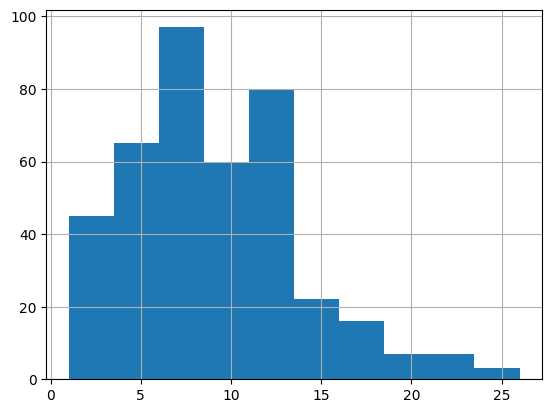

In [49]:
wrigley.runs.hist()

8.80 total runs are scored on average per game. The median is 8 runs per game. This discrepancy between median and mean reflects the right skew of the distribution.

In [50]:
wrigley.runs.describe()

count    402.000000
mean       8.800995
std        4.716417
min        1.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       26.000000
Name: runs, dtype: float64

###Numeric Predictors

There is some significant correlation amongst the numeric predictors. Of particular note is "Wind Speed" which correlates strongly with "Maximum Wind Speed". In addition, "Air Temperature" also correlates negatively with "Wind Speed", "Maximum Wind Speed", "Barometric Pressure", and "Humidity".

<Axes: >

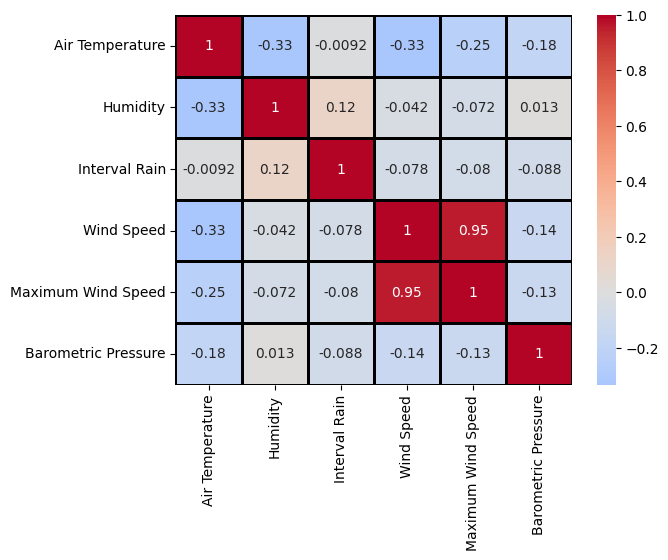

In [51]:
#correlation heatmap
sns.heatmap(wrigley[['Air Temperature','Humidity','Interval Rain','Wind Speed','Maximum Wind Speed','Barometric Pressure']].corr(),
            annot = True,
            fmt = '.2g',
            center = 0,
            cmap = 'coolwarm',
            linewidths = 1,
            linecolor = 'black')

I was surprised that "Humidity" and "Air Temperature" correlate negatively. I always pictured the high humidity days to be steamy afternoons in the summer. A Google search landed on this fun piece of trivia from [weather.gov](https://www.weather.gov/lmk/humidity#:~:text=Warm%20air%20can%20possess%20more,if%20the%20air%20is%20warmer.): "Warm air can possess more water vapor (moisture) than cold air, so with the same amount of absolute/specific humidity, air will have a HIGHER relative humidity if the air is cooler, and a LOWER relative humidity if the air is warmer."

The "Air Temperature" histogram below illustrates the extreme temperatures that hit Chicago. I've experienced as many games at Wrigley in a winter coat as I have in a t-shirt. Perhaps it's because I like to buy tickets when they're cheaper on cold days.

<Axes: >

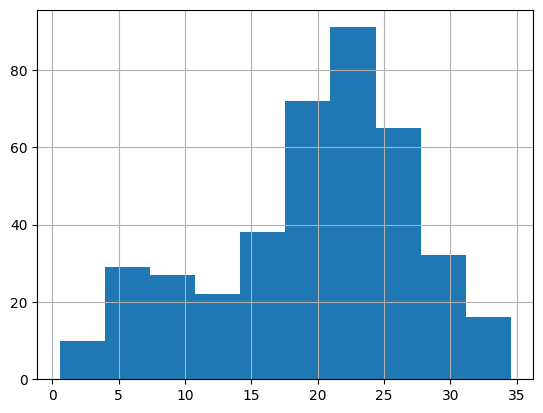

In [52]:
wrigley['Air Temperature'].hist()

The "Humidity" distribution skews left.

<Axes: >

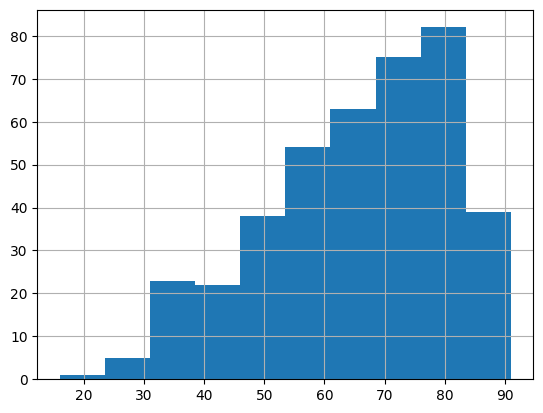

In [53]:
wrigley['Humidity'].hist()

You typically don't play baseball in the rain.

<Axes: >

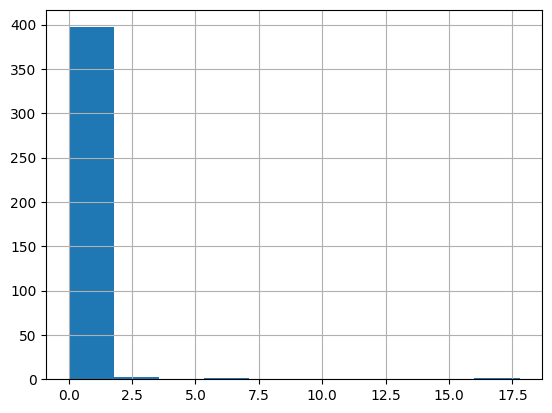

In [54]:
wrigley['Interval Rain'].hist()

The distributions for "Wind Speed" and "Maximum Wind Speed" mirror each other, as expected.

<Axes: >

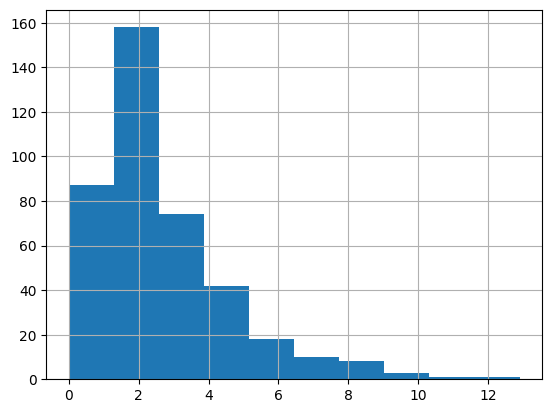

In [55]:
wrigley['Wind Speed'].hist()

<Axes: >

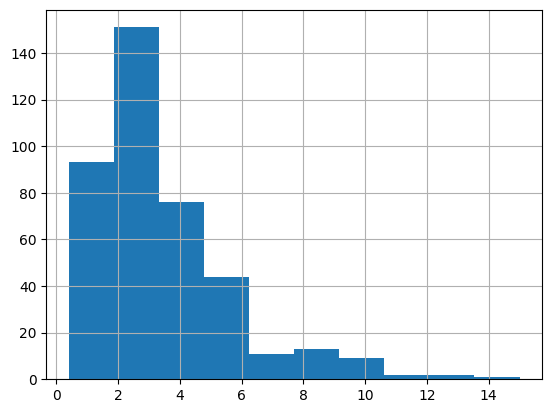

In [56]:
wrigley['Maximum Wind Speed'].hist()

The "Barometric Pressure" histogram is somewhat normally distributed.

<Axes: >

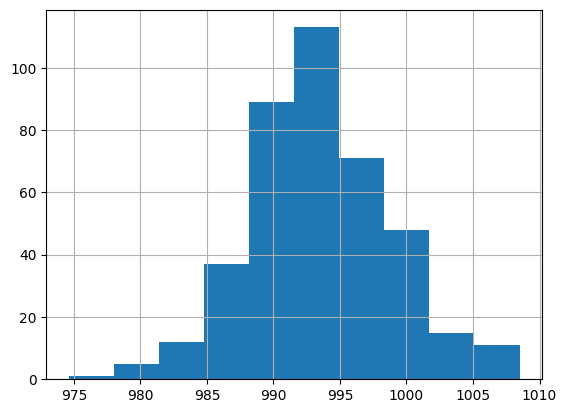

In [57]:
wrigley['Barometric Pressure'].hist()

I fit some way-too-early linear regression models to get a hint at which variables might impact the run total. I began by creating arrays for the scikit-learn library.

In [58]:
y = wrigley.runs.to_numpy()
at = wrigley['Air Temperature'].to_numpy().reshape((-1,1))
h = wrigley['Humidity'].to_numpy().reshape((-1,1))
ir = wrigley['Interval Rain'].to_numpy().reshape((-1,1))
ws = wrigley['Wind Speed'].to_numpy().reshape((-1,1))
mws = wrigley['Maximum Wind Speed'].to_numpy().reshape((-1,1))
bp = wrigley['Barometric Pressure'].to_numpy().reshape((-1,1))

Then I fit the models.

In [59]:
at_model = LinearRegression().fit(at,y)
h_model = LinearRegression().fit(h,y)
ir_model = LinearRegression().fit(ir,y)
ws_model = LinearRegression().fit(ws,y)
mws_model = LinearRegression().fit(mws,y)
bp_model = LinearRegression().fit(bp,y)

In isolation, these numeric predictors are pretty disappointing. My strongest variable is "Air Temperature", and it only accounts 3.2% of the variance in runs scored.

In [60]:
print('Simple Linear Regresion R^2 Values:')
print('Air Temperature:     ', at_model.score(at,y).round(3))
print('Humidity:            ', h_model.score(h,y).round(3))
print('Interval Rain:       ', ir_model.score(ir,y).round(3))
print('Wind Speed:          ', ws_model.score(ws,y).round(3))
print('Maximum Wind Speed:  ', mws_model.score(mws,y).round(3))
print('Barometric Pressure: ', bp_model.score(bp,y).round(3))

Simple Linear Regresion R^2 Values:
Air Temperature:      0.032
Humidity:             0.026
Interval Rain:        0.001
Wind Speed:           0.0
Maximum Wind Speed:   0.0
Barometric Pressure:  0.017


The plot below illustrates how “Air Temperature” (my best predictor) is still weak at explaining Runs Scored. The red line represents the simple linear regression model predictions based on “Air Temperature” alone. The blue dots denote the actual final game scores. And yes, I did pick Cubs colors.

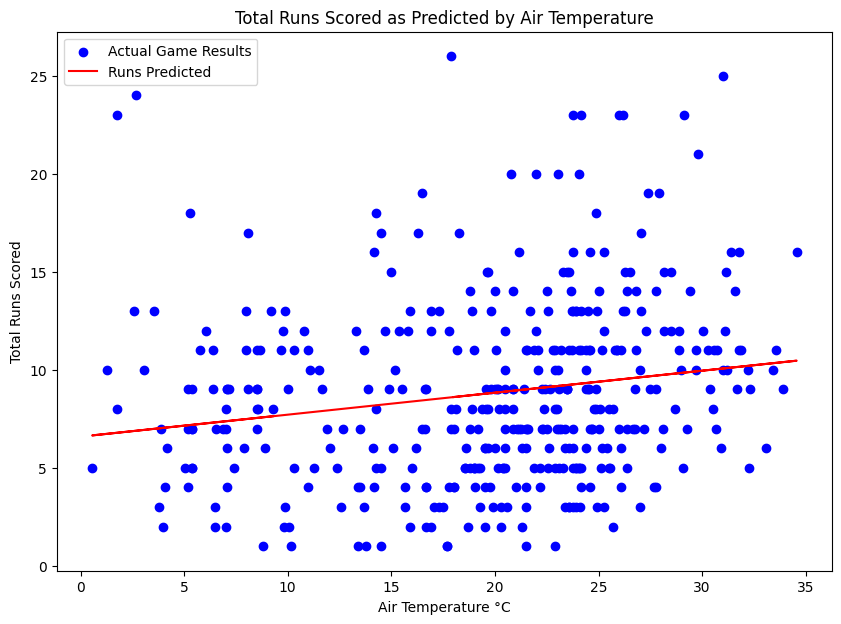

In [61]:
y_pred = at_model.predict(at)
plt.figure(figsize=(10,7))
plt.scatter(at,y,color='b', label="Actual Game Results")
plt.plot(at,y_pred, color='r', label="Runs Predicted")
plt.xlabel("Air Temperature °C")
plt.ylabel("Total Runs Scored")
plt.title("Total Runs Scored as Predicted by Air Temperature")
plt.legend(loc='best')

###Cateogrical Predictor: Wind Direction 

The wind most often blows in from Lake Michigan (from the east).

E    149
N    124
S     84
W     45
Name: Wind_Direction, dtype: int64


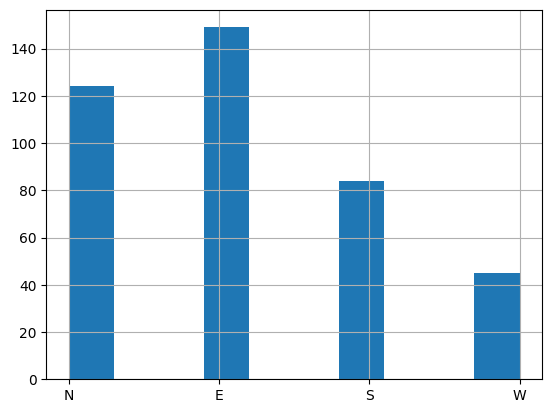

In [62]:
wrigley['Wind_Direction'].hist()
print(wrigley['Wind_Direction'].value_counts())

According to Chicago's famous [Tom Skilling](https://wgntv.com/weather/weather-blog/what-percent-of-the-time-are-chicagos-winds-from-the-northeast/#:~:text=Northeast%2C%20east%20or%20southeast%20winds,most%20frequent%20along%20the%20lakefront.): "Here in Chicago the wind often blows in from Lake Michigan. Northeast, east or southeast winds are frequent, especially during the spring months when air over the lake tends to be colder than temperatures over land. The prevalence of northeast winds varies in the Chicago area, with northeast winds most frequent along the lakefront. There, northeast winds blow, on average, about 40 percent of the time."

This presents a particular challenge to the batters at Wrigley because they are trying to hit the ball out of the park to the northeast. On those cold, windy Chicago spring days, the wind is fighting against the ball's trajectory. I took this Google Earth [screenshot](https://drive.google.com/file/d/15W87ZGAmz0dC09otJUUlS6wJN6YmUO06/view?usp=share_link) of Wrigley Field where the red arrow shows the path of the batted ball and the blue arrow represents the wind blowing in from the northeast.

The table below denotes the mean number of total runs based on the direction of the wind. It makes intuitive sense that when the wind is blowing from the west (and traveling east), the situation is most advantageous for the hitter, and 10.9 runs are scored on average.

In [63]:
#df.groupby(['group_col'])['value_col'].mean()
wrigley.groupby('Wind_Direction')['runs'].mean().sort_values(ascending=False)

Wind_Direction
W    11.244444
S    10.059524
E     8.140940
N     7.854839
Name: runs, dtype: float64

This boxplot illustrating total runs scored by wind direction also hints that the wind direction might be a significant predictor of runs scored.

<Axes: title={'center': 'runs'}, xlabel='Wind_Direction'>

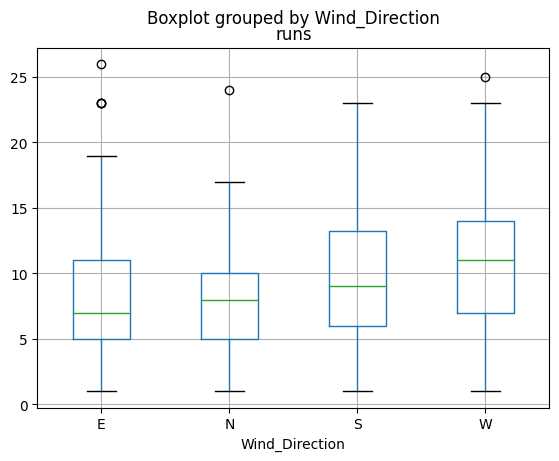

In [64]:
#df.boxplot(column=['Col1', 'Col2'], by=['X', 'Y'])
wrigley.boxplot(column='runs', by='Wind_Direction')

Similar to an ANOVA test but without assuming normality, the Kruskal Wallis test demonstrates a near 0% chance that the distinctions in median runs scored by wind direction are due to chance.

In [65]:
stats.kruskal(wrigley.runs[wrigley.Wind_Direction == 'E'], wrigley.runs[wrigley.Wind_Direction == 'N'], wrigley.runs[wrigley.Wind_Direction == 'S'], wrigley.runs[wrigley.Wind_Direction == 'W'])

KruskalResult(statistic=24.395024428768668, pvalue=2.065839787508899e-05)

#Train/Test Split

First, I converted "Wind_Direction" into dummy variables.

In [66]:
dummies = pd.get_dummies(wrigley)
dummies.head()

,start_rounded,runs,Air Temperature,Humidity,Interval Rain,Wind Speed,Maximum Wind Speed,Barometric Pressure,Wind_Direction_E,Wind_Direction_N,Wind_Direction_S,Wind_Direction_W
0,2016-04-12 00:00:00+00:00,8.0,9.28,30,0.0,2.5,3.0,993.2,0,1,0,0
1,2016-04-14 00:00:00+00:00,11.0,5.78,68,0.0,4.1,4.7,1001.7,1,0,0,0
2,2016-04-15 00:00:00+00:00,9.0,7.06,66,0.0,1.8,1.9,999.3,0,1,0,0
3,2016-04-15 18:00:00+00:00,7.0,7.00,70,0.0,2.6,2.8,1001.4,0,1,0,0
4,2016-04-16 18:00:00+00:00,8.0,8.56,72,0.0,1.8,2.0,1003.7,0,1,0,0


Then, I subset 20% of my data for model evaluation.

In [67]:
train, test = train_test_split(dummies,
                               random_state=4, 
                                test_size=0.20, 
                                shuffle=True)

Finally, I separated the X and y variables.

In [68]:
X_train = train[['Air Temperature',	'Humidity',	'Interval Rain',	'Wind Speed',	'Maximum Wind Speed',	'Barometric Pressure',	'Wind_Direction_S',	'Wind_Direction_N',	'Wind_Direction_W']]
y_train = train['runs']
X_test = test[['Air Temperature',	'Humidity',	'Interval Rain',	'Wind Speed',	'Maximum Wind Speed',	'Barometric Pressure',	'Wind_Direction_S',	'Wind_Direction_N',	'Wind_Direction_W']]
y_test = test['runs']

#Regression

###Wind Direction

Before fitting my regression models with forward selection, I explored "Wind_Direction" to get a sense of this variable's predictive power and how to model it.

I began by leaving out the dummy coded "Wind_Direction_E" because this is the most frequent wind direction on Lake Michigan. In essence, "Wind_Direction_E" is my control group, and all the other wind directions with coefficients are my experimental groups.

This original wind model is relatively promising. It has an adjusted R^2 value 0f 0.050, which would beat out all the numeric variables as the strongest predictor. However, the "Wind_Direction_N" variable is not statistically significant with a p-value of 0.156. 

In [69]:
model_1 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W + Wind_Direction_N", data=train).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     6.592
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000247
Time:                        22:40:30   Log-Likelihood:                -934.83
No. Observations:                 321   AIC:                             1878.
Df Residuals:                     317   BIC:                             1893.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.5214      0.414  

To test whether I can group "Wind_Direction_N" and "Wind_Direction_E" together as the same categorical variable, I ran a Mann Whitney U test. Similar to a t-test but without assuming normality, the p-value here denotes that there is a 28.3% chance that the distinctions in median runs scored between eastern and northern winds are due to chance.

In [70]:
from scipy.stats import mannwhitneyu
mannwhitneyu(train.runs[train.Wind_Direction_E == 1], train.runs[train.Wind_Direction_N == 1])

MannwhitneyuResult(statistic=6529.5, pvalue=0.2834260097372592)

Because I could not prove there was a predictive distinction between eastern and northern winds, I grouped them together as the same categorical variable. I accomplished this by leaving out both the “Wind_Direction_N” and “Wind_Direction_E” dummy variables. The adjusted R^2 value drops to 0.047, but the AIC remains the same at 1878. More importantly, all the predictors have a p-value less than 0.05. Looking at the intercept coefficient, when the wind blows from the east or north, this model predicts 8.12 runs. When the wind blows from the south, the model predicts an additional 1.79 runs, 9.91 total. When the wind blows from the west, the model predicts an additional 2.88 runs, 11.00 total.

In [71]:
model_2 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W", data=train).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     8.848
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000182
Time:                        22:40:31   Log-Likelihood:                -935.85
No. Observations:                 321   AIC:                             1878.
Df Residuals:                     318   BIC:                             1889.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.1182      0.303  

I explored interaction effects between "Wind Speed" and wind direction. While this bumps the adjusted R^2 value up to 0.049, it comes at the expense of an increased AIC (1880) and statistically insignificant p-values for most of the variables. For these reasons, I rejected including interaction effects in my models.

In [72]:
model_3 = ols(formula="runs ~ Q('Wind Speed')*Wind_Direction_S + Q('Wind Speed')*Wind_Direction_W", data=train).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.271
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000900
Time:                        22:40:31   Log-Likelihood:                -934.02
No. Observations:                 321   AIC:                             1880.
Df Residuals:                     315   BIC:                             1903.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

###Forward Selection

I fit my linear regression models using forward selection with the numeric variables. To evaluate the strength of a model, I looked at the individual variables' p-values (<0.05), the model's AIC, and finally the adjusted R^2. In the end, none of the numeric predictors significantly improved the model beyond "Air Temperature".

Starting with wind direction as my base predictor, I introduced the numeric variables in the order of their simple linear regression R^2 values when fit to the whole dataset. 

In [73]:
print('Simple Linear Regresion R^2 Values:')
print('Air Temperature:     ', at_model.score(at,y).round(3))
print('Humidity:            ', h_model.score(h,y).round(3))
print('Interval Rain:       ', ir_model.score(ir,y).round(3))
print('Wind Speed:          ', ws_model.score(ws,y).round(3))
print('Maximum Wind Speed:  ', mws_model.score(mws,y).round(3))
print('Barometric Pressure: ', bp_model.score(bp,y).round(3))

Simple Linear Regresion R^2 Values:
Air Temperature:      0.032
Humidity:             0.026
Interval Rain:        0.001
Wind Speed:           0.0
Maximum Wind Speed:   0.0
Barometric Pressure:  0.017


“Air Temperature” is a statistically significant predictor on top of the wind direction. When compared to model_2 (just wind direction) the adjusted R^2 increases from 0.047 to 0.059. In addition, the AIC drops from 1878 to 1875, and all the predictors have a p-value less than 0.05. For these reasons, I retained "Air Temperature" as a predictor.

I eventually designated model_4 as my "best" regression model due to the poor predictive power of the following weather variables. In the Model Evaluation subsection, I analyzed these regression results in further detail.

In [74]:
model_4 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W + Q('Air Temperature')", data=train).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.658
Date:                Sat, 06 May 2023   Prob (F-statistic):           5.89e-05
Time:                        22:40:31   Log-Likelihood:                -933.32
No. Observations:                 321   AIC:                             1875.
Df Residuals:                     317   BIC:                             1890.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6241 

"Humidity" was not retained in the regression model on top of wind direction and "Air Temperature" because of the diminished adjusted R^2 value (0.059 to 0.056), the increased AIC value (1875 to 1876), and the statistically insignificant predictor p-value of 0.665.

In [75]:
model_5 = ols(formula="runs ~Wind_Direction_S	+ Wind_Direction_W + Q('Air Temperature') + Humidity", data=train).fit()
print(model_5.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     5.776
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000169
Time:                        22:40:31   Log-Likelihood:                -933.22
No. Observations:                 321   AIC:                             1876.
Df Residuals:                     316   BIC:                             1895.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.2371 

"Barometric Pressure" was not retained in the regression model because of the diminished adjusted R^2 value (0.059 to 0.057), the increased AIC value (1875 to 1876), and the statistically insignificant predictor p-value of 0.574.

In [76]:
model_6 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W + Q('Air Temperature') + Q('Barometric Pressure')", data=train).fit()
print(model_6.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     5.810
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000160
Time:                        22:40:31   Log-Likelihood:                -933.15
No. Observations:                 321   AIC:                             1876.
Df Residuals:                     316   BIC:                             1895.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

"Interval Rain" did not have much impact on the model. Both the adjusted R^2 and AIC values remained the same at 0.059 and 1875, respectively. I chose not to retain this variable due to its statistically insignificant p-value of 0.276 and its failure to improve the model's predictive power.

In [77]:
model_7 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W + Q('Air Temperature') + Q('Interval Rain')", data=train).fit()
print(model_7.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     6.044
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000107
Time:                        22:40:31   Log-Likelihood:                -932.71
No. Observations:                 321   AIC:                             1875.
Df Residuals:                     316   BIC:                             1894.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6725 

I tested "Wind Speed" without interaction effects but chose not to retain this variable because the adjusted R^2 value diminished from 0.059 to 0.057. Likewise, the AIC value increased from 1875 to 1876. The predictor p-value is statistically insignificant at 0.570.

In [78]:
model_8 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W + Q('Air Temperature') + Q('Wind Speed')", data=train).fit()
print(model_8.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     5.812
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000159
Time:                        22:40:31   Log-Likelihood:                -933.15
No. Observations:                 321   AIC:                             1876.
Df Residuals:                     316   BIC:                             1895.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.0116 

Lastly, I tested "Maximum Wind Speed" but chose not to retain this variable because the adjusted R^2 value diminished from 0.059 to 0.056. Likewise, the AIC value increased from 1875 to 1877. The predictor p-value is statistically insignificant at 0.763.

In [79]:
model_9 = ols(formula="runs ~ Wind_Direction_S	+ Wind_Direction_W + Q('Air Temperature') + Q('Maximum Wind Speed')", data=train).fit()
print(model_9.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     5.750
Date:                Sat, 06 May 2023   Prob (F-statistic):           0.000177
Time:                        22:40:31   Log-Likelihood:                -933.27
No. Observations:                 321   AIC:                             1877.
Df Residuals:                     316   BIC:                             1895.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

###Model Evaluation

The following table summarizes results from the regression model selection.

In [80]:
# assign data
mydata = [
    ["Model_1", "'Wind_Direction_SWN'",  "Yes", "0.050", "1878", ""],
    ["Model_2", "'Wind_Direction_SW'", "No", "0.047", "1878", ""],
    ["Model_3", "'Wind Speed'*'Wind_Direction_SW'", "Yes", "0.049", "1880", ""],
    ["Model_4", "'Wind_Direction_SW' 'Air Temperature'", "No", "0.059", "1875", "*****"],
    ["Model_5", "'Wind_Direction_SW' 'Air Temperature' 'Humidity'", "Yes", "0.056", "1876", ""],
    ["Model_6", "'Wind_Direction_SW' 'Air Temperature' 'Barometric Pressure'", "Yes", "0.057", "1876", ""],
    ["Model_7", "'Wind_Direction_SW' 'Air Temperature' 'Interval Rain'", "Yes", "0.059", "1875", ""],
    ["Model_8", "'Wind_Direction_SW' 'Air Temperature' 'Wind Speed'", "Yes", "0.057", "1876", ""],
    ["Model_9", "'Wind_Direction_SW' 'Air Temperature' 'Interval Rain'", "Yes", "0.056", "1877", ""],
]
 
# create header
head = ["Model Number", "Predictors", "Insignifcant P-Values", "Adj R^2", "AIC", "Best Model"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------+-------------------------------------------------------------+-------------------------+-----------+-------+--------------+
| Model Number   | Predictors                                                  | Insignifcant P-Values   |   Adj R^2 |   AIC | Best Model   |
+================+=============================================================+=========================+===========+=======+==============+
| Model_1        | 'Wind_Direction_SWN'                                        | Yes                     |     0.05  |  1878 |              |
+----------------+-------------------------------------------------------------+-------------------------+-----------+-------+--------------+
| Model_2        | 'Wind_Direction_SW'                                         | No                      |     0.047 |  1878 |              |
+----------------+-------------------------------------------------------------+-------------------------+-----------+-------+--------------+
| Mode

I designated Model_4 as my "best" regression model due to its superior adjusted R^2 and AIC values and statistically significant predictors.

In [81]:
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                   runs   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.658
Date:                Sat, 06 May 2023   Prob (F-statistic):           5.89e-05
Time:                        22:40:31   Log-Likelihood:                -933.32
No. Observations:                 321   AIC:                             1875.
Df Residuals:                     317   BIC:                             1890.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6241 

Model_4 is illustrated by the plot below. Like before, the blue dots represent the scores from the actual games in the training dataset. Regardless of the direction of the wind, for each degree increase in temperature in Celsius, an 0.0826 additional runs are predicted to be scored. The red line represents the predicted total runs scored when the wind is blowing from the east or north. The gray line represents the predictions when the wind is blowing from the south. When the wind blows from the south, an additional 1.3793 runs are forecast as compared to when the wind blows from the east or north. The black line represents the predictions when the wind is blowing west. When the wind blows from the west, an additional 2.3878 runs are forecast as compared to when the wind blows from the east or north.

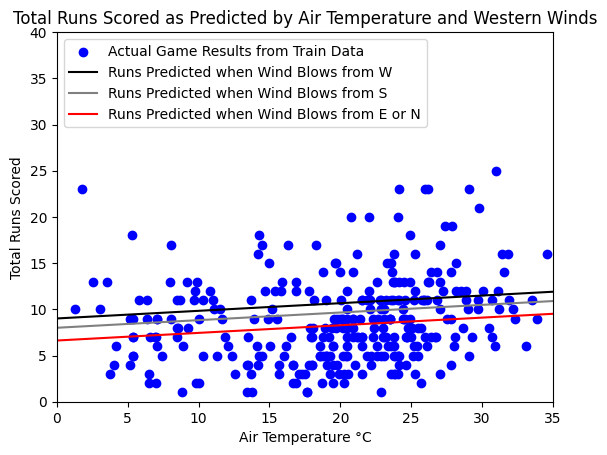

In [82]:
y = y_train.to_numpy()
at = X_train['Air Temperature'].to_numpy().reshape((-1,1))

x = np.linspace(0,35)
y1 = 0.0826*x+6.6241
y2= 0.0826*x+(1.3793+6.6241)
y3= 0.0826*x+(2.3878+6.6241)
plt.axis([0, 35, 0, 40])
plt.scatter(at,y,color='b', label="Actual Game Results from Train Data")
plt.plot(x,y3,color='black', label="Runs Predicted when Wind Blows from W")
plt.plot(x,y2,color='gray', label="Runs Predicted when Wind Blows from S")
plt.plot(x,y1,color='r', label="Runs Predicted when Wind Blows from E or N")
plt.xlabel("Air Temperature °C")
plt.ylabel("Total Runs Scored")
plt.title("Total Runs Scored as Predicted by Air Temperature and Western Winds")
plt.legend(loc='upper left')

I checked for heteroskedasticity, using the residual plots in the top right corner. There is no evidence that the errors are non-constant across "Air Temperature".

eval_env: 1


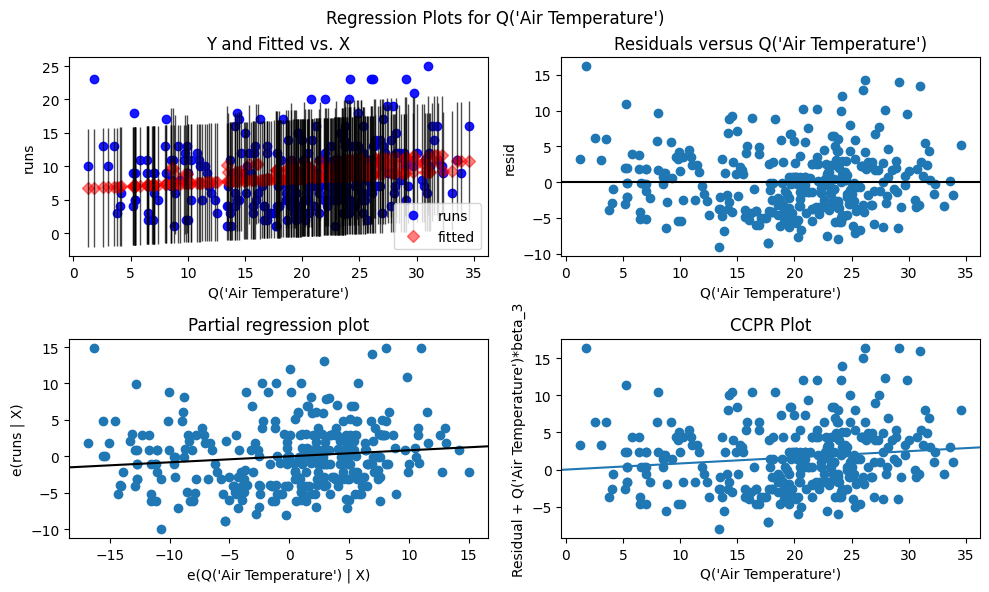

In [83]:
# modify figure size
fig = plt.figure(figsize=(10, 6))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model_4,
                                    "Q('Air Temperature')",
                                    fig=fig)

To compare my best regression model to future machine learning models, I calculated a MAE of 3.503 runs against train data and 3.633 runs against test data.

In [84]:
from statsmodels.tools.eval_measures import meanabs

#generate predictions
y_train_pred = model_4.predict(X_train)
y_test_pred = model_4.predict(X_test)

# calc MAE
print("Train MAE:", meanabs(y_train, y_train_pred))
print("Test MAE:", meanabs(y_test, y_test_pred))

Train MAE: 3.502665617480053
Test MAE: 3.6333614451002454


This small discrepancy between train and test data hints at moderate issues with overfitting. The plot below illustrates the regression model's predictions against the test data.

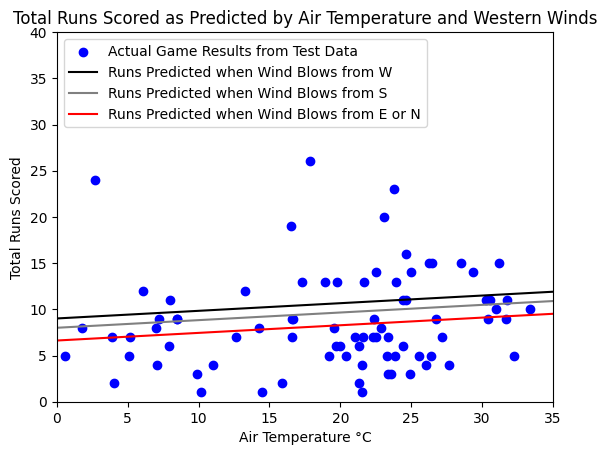

In [85]:
y = y_test.to_numpy()
at = X_test['Air Temperature'].to_numpy().reshape((-1,1))

x = np.linspace(0,35)
y1 = 0.0826*x+6.6241
y2= 0.0826*x+(1.3793+6.6241)
y3= 0.0826*x+(2.3878+6.6241)
plt.axis([0, 35, 0, 40])
plt.scatter(at,y,color='b', label="Actual Game Results from Test Data")
plt.plot(x,y3,color='black', label="Runs Predicted when Wind Blows from W")
plt.plot(x,y2,color='gray', label="Runs Predicted when Wind Blows from S")
plt.plot(x,y1,color='r', label="Runs Predicted when Wind Blows from E or N")
plt.xlabel("Air Temperature °C")
plt.ylabel("Total Runs Scored")
plt.title("Total Runs Scored as Predicted by Air Temperature and Western Winds")
plt.legend(loc='upper left')

#Random Forest

###Baseline Model

I fit a random forest model to the train data with baseline parameters.

In [86]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 4).fit(X_train, y_train)

I then calculated the MAE against the train and test data with values of 2.860 and 3.878 runs, respectively. The discrepancy in MAE between the two data sets suggests that the model is strongly overfit to the train data.

In [87]:
train_prediction = rf.predict(X_train)
train_mae = mean_absolute_error(y_train, train_prediction)
print("Train MAE", train_mae)

test_prediction = rf.predict(X_test)
test_mae = mean_absolute_error(y_test, test_prediction)
print("Test MAE", test_mae)

Train MAE 2.8596849162053286
Test MAE 3.8780884410775553


###Grid Search Optimized Model

To try to optimize the model, I employed GridSearchCV to test multiple sets of parameters and fit a model to the best one.

In [88]:
## Define Grid 
grid = { 
    'n_estimators': [200,300,400],
    'max_features': ['sqrt','log2'],
    'max_depth' : [4,5,6],
    'random_state' : [4]
}
## show start time
print("Start time: ", datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)
## show end time
print("End time: ",datetime.now())

Start time:  2023-05-06 22:40:35.131862
End time:  2023-05-06 22:41:14.143516


The optimized parameters changed from 300 to 200 estimators, and the max depth decreased from 5 to 4.

In [89]:
CV_rfr.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'random_state': 4}

I then fit a model with these parameters.

In [90]:
rf_opt = RandomForestRegressor(n_estimators = 200, max_features = 'sqrt', max_depth = 4, random_state = 4).fit(X_train, y_train)

I calculated the MAE for my optimized model at 3.047 runs with train data and 3.861 runs with the test data. The discrepancy between train and test MAE slightly narrowed because I shrunk the dimensions of the random forest.

In [91]:
train_prediction = rf_opt.predict(X_train)
train_mae = mean_absolute_error(y_train, train_prediction)
print("Train MAE", train_mae)

test_prediction = rf_opt.predict(X_test)
test_mae = mean_absolute_error(y_test, test_prediction)
print("Test MAE", test_mae)

Train MAE 3.047087160802218
Test MAE 3.8613936317792144


###Model Evaluation

The table below compares the train and test MAE values for both random forest models. I designated the GridSearch Optimized Model as my "best" random forest model because it is less overfit and demonstrates a lower test data MAE value.

In [92]:
# assign data
mydata = [
    ["Baseline Model", "2.860", "3.878", ""],
    ["Grid Search Optimized Model", "3.047", "3.861","*****"],
]
 
# create header
head = ["Model Type", "Train MAE", "Test MAE", "Best Model"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+-----------------------------+-------------+------------+--------------+
| Model Type                  |   Train MAE |   Test MAE | Best Model   |
+=============================+=============+============+==============+
| Baseline Model              |       2.86  |      3.878 |              |
+-----------------------------+-------------+------------+--------------+
| Grid Search Optimized Model |       3.047 |      3.861 | *****        |
+-----------------------------+-------------+------------+--------------+


The density plot below denotes the frequency of predictions generated by the baseline "best" random forest model against the actual results of the test data. The model predicts that all games will produce between 6.194 and 12.683 runs.

Max prediction = 12.682820443313512 runs
Min prediction = 6.194001102887771 runs


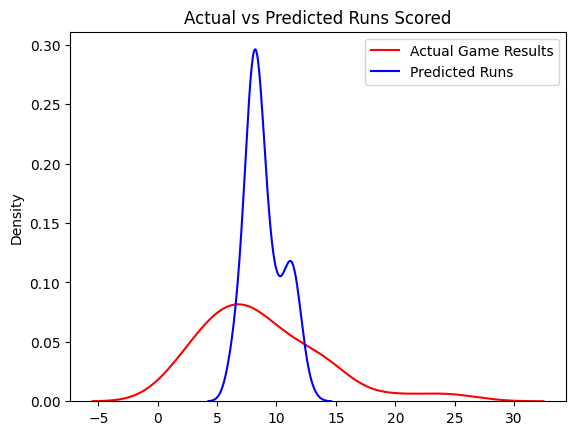

In [93]:
test_prediction = rf.predict(X_test)
ax = sns.kdeplot(y_test.ravel(), color="r", label="Actual Game Results")
sns.kdeplot(test_prediction, color="b", label="Predicted Runs")
plt.title('Actual vs Predicted Runs Scored')
plt.legend(loc='best')
print("Max prediction =", test_prediction.max(), "runs")
print("Min prediction =", test_prediction.min(), "runs")

Random forests are black box models, meaning it is difficult to understand how each calculation is made. However, by studying feature importance, I can see which variables exert the most influence on the predictions of the "best" model. "Air Temperature" has the greatest importance, but the random forest model also pulls heavily from "Barometric Pressure", "Maximum Wind Speed", "Wind Speed", and "Humidity".

Text(0.5, 1.0, 'Random Forest Feature Importance')

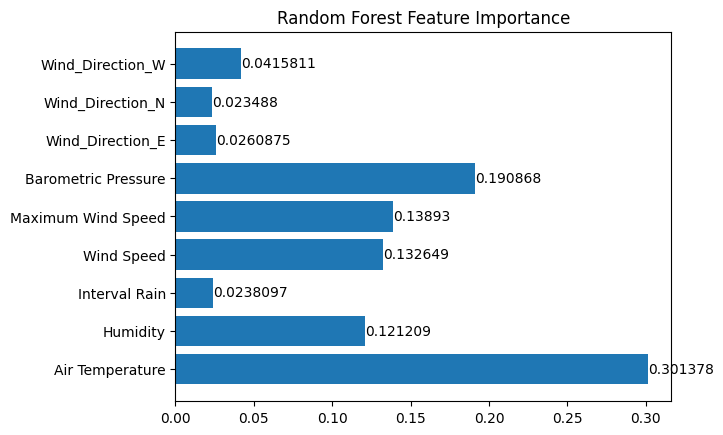

In [94]:
order = ['Air Temperature',	'Humidity',	'Interval Rain',	'Wind Speed',	'Maximum Wind Speed',	'Barometric Pressure', 'Wind_Direction_E',	'Wind_Direction_N',	'Wind_Direction_W']
fig, ax = plt.subplots()
bars = ax.barh(order, rf.feature_importances_)
ax.bar_label(bars)
plt.title('Random Forest Feature Importance')

#Neural Network

To find the best parameters, I ran five models with different numbers of nodes and/or layers. Because overfitting was an issue with the regression and random forest models, I also introduced regularizers with A/B testing.

###Model Fitting

To prepare for TensorFlow neural networks, I converted the data into arrays. I also normalized the predictors.

In [95]:
X_train_norm = preprocessing.normalize(X_train.to_numpy())
X_test_norm = preprocessing.normalize(X_test.to_numpy())
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

My first model only has one dense layer with 10 nodes.

In [96]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_1a=tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_1a.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_1a.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.6680 - mean_absolute_error: 8.6680
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.5142 - mean_absolute_error: 8.5142
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.3868 - mean_absolute_error: 8.3868
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.2630 - mean_absolute_error: 8.2630
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.1387 - mean_absolute_error: 8.1387
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.0120 - mean_absolute_error: 8.0120
Epoch 7/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.8812 - mean_absolute_error: 7.8812
Epoch 8/1000
11/11 [==============================] - 0s 2ms/step - loss: 7.7490 - mean_absolute_error: 7.7490
Epoch 9/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.6156 - mean_absolute_error: 7.6156
E

The first model produces a MAE of 3.6014 and 3.9536 runs with the train and test data, respectively.

In [97]:
print("Train MAE:", nn_model_1a.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_1a.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 2ms/step - loss: 3.6014 - mean_absolute_error: 3.6014
Train MAE: [3.601428747177124, 3.601428747177124]
3/3 [==============================] - 0s 3ms/step - loss: 3.9536 - mean_absolute_error: 3.9536
Test MAE: [3.9535627365112305, 3.9535627365112305]


I then ran an identical model with regularizers to possibly reduce overfitting.

In [98]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_1b=tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_1b.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_1b.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.9037 - mean_absolute_error: 8.6686
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.7422 - mean_absolute_error: 8.5163
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.6090 - mean_absolute_error: 8.3901
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.4799 - mean_absolute_error: 8.2675
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.3509 - mean_absolute_error: 8.1447
Epoch 6/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.2209 - mean_absolute_error: 8.0203
Epoch 7/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.0877 - mean_absolute_error: 7.8922
Epoch 8/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.9526 - mean_absolute_error: 7.7615
Epoch 9/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.8175 - mean_absolute_error: 7.6307
E

The first model (regularized) now produces a MAE of 3.6020 and 3.9096 runs with the train and test data, respectively.

In [99]:
print("Train MAE:", nn_model_1b.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_1b.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 1ms/step - loss: 3.7505 - mean_absolute_error: 3.6020
Train MAE: [3.7505414485931396, 3.6020424365997314]
3/3 [==============================] - 0s 2ms/step - loss: 4.0581 - mean_absolute_error: 3.9096
Test MAE: [4.058064937591553, 3.9095888137817383]


My second model contains two dense layers with 10 nodes each.

In [100]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_2a=tf.keras.Sequential([
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_2a.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_2a.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.6297 - mean_absolute_error: 8.6297
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 8.2183 - mean_absolute_error: 8.2183
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.8529 - mean_absolute_error: 7.8529
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 7.4927 - mean_absolute_error: 7.4927
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.1109 - mean_absolute_error: 7.1109
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - loss: 6.7080 - mean_absolute_error: 6.7080
Epoch 7/1000
11/11 [==============================] - 0s 1ms/step - loss: 6.3015 - mean_absolute_error: 6.3015
Epoch 8/1000
11/11 [==============================] - 0s 1ms/step - loss: 5.8814 - mean_absolute_error: 5.8814
Epoch 9/1000
11/11 [==============================] - 0s 1ms/step - loss: 5.4885 - mean_absolute_error: 5.4885
E

The second model produces a MAE of 3.5976 and 3.9348 runs with the train and test data, respectively.

In [101]:
#check the results with insurnce model test data
print("Train MAE:", nn_model_2a.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_2a.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 2ms/step - loss: 3.5976 - mean_absolute_error: 3.5976
Train MAE: [3.597566843032837, 3.597566843032837]
3/3 [==============================] - 0s 3ms/step - loss: 3.9348 - mean_absolute_error: 3.9348
Test MAE: [3.9347877502441406, 3.9347877502441406]


I reran the second model with regularizers to possibly reduce overfitting.

In [102]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_2b=tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1(0.1), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.L1(0.1), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_2b.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_2b.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 1s 2ms/step - loss: 13.7069 - mean_absolute_error: 8.6712
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 13.1789 - mean_absolute_error: 8.3242
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 12.7295 - mean_absolute_error: 8.0160
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 12.2916 - mean_absolute_error: 7.7068
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 11.8525 - mean_absolute_error: 7.3877
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - loss: 11.3952 - mean_absolute_error: 7.0438
Epoch 7/1000
11/11 [==============================] - 0s 1ms/step - loss: 10.9406 - mean_absolute_error: 6.6962
Epoch 8/1000
11/11 [==============================] - 0s 1ms/step - loss: 10.4903 - mean_absolute_error: 6.3455
Epoch 9/1000
11/11 [==============================] - 0s 1ms/step - loss: 10.0318 - mean_absolute_error:

The second model (regularized) now produces a MAE of 3.6225 and 3.9101 runs with the train and test data, respectively.

In [103]:
#check the results with insurnce model test data
print("Train MAE:", nn_model_2b.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_2b.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 1ms/step - loss: 4.2733 - mean_absolute_error: 3.6225
Train MAE: [4.273349761962891, 3.622535467147827]
3/3 [==============================] - 0s 3ms/step - loss: 4.5609 - mean_absolute_error: 3.9101
Test MAE: [4.5608696937561035, 3.9100542068481445]


My third model contains one dense layer with 100 nodes.

In [104]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_3a=tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_3a.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_3a.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.3380 - mean_absolute_error: 8.3380
Epoch 2/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.7634 - mean_absolute_error: 7.7634
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.2845 - mean_absolute_error: 7.2845
Epoch 4/1000
11/11 [==============================] - 0s 1ms/step - loss: 6.7997 - mean_absolute_error: 6.7997
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 6.3146 - mean_absolute_error: 6.3146
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - loss: 5.8207 - mean_absolute_error: 5.8207
Epoch 7/1000
11/11 [==============================] - 0s 1ms/step - loss: 5.3523 - mean_absolute_error: 5.3523
Epoch 8/1000
11/11 [==============================] - 0s 1ms/step - loss: 4.9092 - mean_absolute_error: 4.9092
Epoch 9/1000
11/11 [==============================] - 0s 1ms/step - loss: 4.5895 - mean_absolute_error: 4.5895
E

The third model produces a MAE of 3.5951 and 3.9355 runs with the train and test data, respectively.

In [105]:
print("Train MAE:", nn_model_3a.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_3a.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 3ms/step - loss: 3.5951 - mean_absolute_error: 3.5951
Train MAE: [3.5950863361358643, 3.5950863361358643]
3/3 [==============================] - 0s 5ms/step - loss: 3.9355 - mean_absolute_error: 3.9355
Test MAE: [3.9354779720306396, 3.9354779720306396]


I reran the third model with regularizers to possibly reduce overfitting.

In [106]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_3b=tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_3b.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_3b.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 1s 2ms/step - loss: 9.3383 - mean_absolute_error: 8.3444
Epoch 2/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.6781 - mean_absolute_error: 7.7823
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.1400 - mean_absolute_error: 7.3140
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 7.6056 - mean_absolute_error: 6.8407
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 7.0806 - mean_absolute_error: 6.3697
Epoch 6/1000
11/11 [==============================] - 0s 2ms/step - loss: 6.5459 - mean_absolute_error: 5.8827
Epoch 7/1000
11/11 [==============================] - 0s 2ms/step - loss: 6.0508 - mean_absolute_error: 5.4311
Epoch 8/1000
11/11 [==============================] - 0s 2ms/step - loss: 5.5728 - mean_absolute_error: 4.9900
Epoch 9/1000
11/11 [==============================] - 0s 2ms/step - loss: 5.2308 - mean_absolute_error: 4.6876
E

The third model (regularized) now produces a MAE of 3.5989 and 3.9228 runs with the train and test data, respectively.

In [107]:
print("Train MAE:", nn_model_3b.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_3b.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 2ms/step - loss: 3.7524 - mean_absolute_error: 3.5989
Train MAE: [3.752408742904663, 3.598938465118408]
3/3 [==============================] - 0s 7ms/step - loss: 4.0763 - mean_absolute_error: 3.9228
Test MAE: [4.076287746429443, 3.9228172302246094]


My fourth model contains two dense layers with 100 nodes each.

In [108]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_4a=tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_4a.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_4a.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 0s 2ms/step - loss: 7.1369 - mean_absolute_error: 7.1369
Epoch 2/1000
11/11 [==============================] - 0s 2ms/step - loss: 4.2870 - mean_absolute_error: 4.2870
Epoch 3/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6102 - mean_absolute_error: 3.6102
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 3.6438 - mean_absolute_error: 3.6438
Epoch 5/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6150 - mean_absolute_error: 3.6150
Epoch 6/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6253 - mean_absolute_error: 3.6253
Epoch 7/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6049 - mean_absolute_error: 3.6049
Epoch 8/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6404 - mean_absolute_error: 3.6404
Epoch 9/1000
11/11 [==============================] - 0s 1ms/step - loss: 3.6180 - mean_absolute_error: 3.6180
E

The fourth model produces a MAE of 3.6323 and 3.9896 runs with the train and test data, respectively.

In [109]:
print("Train MAE:", nn_model_4a.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_4a.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 1ms/step - loss: 3.6323 - mean_absolute_error: 3.6323
Train MAE: [3.6322832107543945, 3.6322832107543945]
3/3 [==============================] - 0s 3ms/step - loss: 3.9896 - mean_absolute_error: 3.9896
Test MAE: [3.989600658416748, 3.989600658416748]


I reran the fourth model with regularizers to possibly reduce overfitting.

In [110]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_4b=tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_4b.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_4b.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 1s 3ms/step - loss: 16.6918 - mean_absolute_error: 7.3756
Epoch 2/1000
11/11 [==============================] - 0s 2ms/step - loss: 13.5117 - mean_absolute_error: 4.7957
Epoch 3/1000
11/11 [==============================] - 0s 2ms/step - loss: 11.9356 - mean_absolute_error: 3.7787
Epoch 4/1000
11/11 [==============================] - 0s 2ms/step - loss: 11.1368 - mean_absolute_error: 3.7347
Epoch 5/1000
11/11 [==============================] - 0s 2ms/step - loss: 10.3859 - mean_absolute_error: 3.6277
Epoch 6/1000
11/11 [==============================] - 0s 2ms/step - loss: 9.7131 - mean_absolute_error: 3.6241
Epoch 7/1000
11/11 [==============================] - 0s 2ms/step - loss: 9.0933 - mean_absolute_error: 3.6594
Epoch 8/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.5286 - mean_absolute_error: 3.6184
Epoch 9/1000
11/11 [==============================] - 0s 2ms/step - loss: 8.0089 - mean_absolute_error: 3.6

The fourth model (regularized) now produces a MAE of 3.6402 and 3.9165 runs with the train and test data, respectively.

In [111]:
print("Train MAE:", nn_model_4b.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_4b.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 1ms/step - loss: 3.8435 - mean_absolute_error: 3.6402
Train MAE: [3.843466281890869, 3.640181541442871]
3/3 [==============================] - 0s 4ms/step - loss: 4.1198 - mean_absolute_error: 3.9165
Test MAE: [4.1197943687438965, 3.916508913040161]


My fifth model contains 5 dense layers with 100, 200, 300, 400, and 500 nodes in that order. 

In [112]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_5a=tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(200),
    tf.keras.layers.Dense(300),
    tf.keras.layers.Dense(400),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_5a.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_5a.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 1s 6ms/step - loss: 5.7000 - mean_absolute_error: 5.7000
Epoch 2/1000
11/11 [==============================] - 0s 5ms/step - loss: 3.8464 - mean_absolute_error: 3.8464
Epoch 3/1000
11/11 [==============================] - 0s 8ms/step - loss: 4.1351 - mean_absolute_error: 4.1351
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 3.9193 - mean_absolute_error: 3.9193
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 3.9054 - mean_absolute_error: 3.9054
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 4.4664 - mean_absolute_error: 4.4664
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 3.8269 - mean_absolute_error: 3.8269
Epoch 8/1000
11/11 [==============================] - 0s 5ms/step - loss: 4.2410 - mean_absolute_error: 4.2410
Epoch 9/1000
11/11 [==============================] - 0s 5ms/step - loss: 4.0686 - mean_absolute_error: 4.0686
E

The fifth model produces a MAE of 4.0613 and 4.2512 runs with the train and test data, respectively.

In [113]:
#check the results with insurnce model test data
print("Train MAE:", nn_model_5a.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_5a.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 2ms/step - loss: 4.1375 - mean_absolute_error: 4.1375
Train MAE: [4.137456893920898, 4.137456893920898]
3/3 [==============================] - 0s 4ms/step - loss: 4.3211 - mean_absolute_error: 4.3211
Test MAE: [4.321069240570068, 4.321069240570068]


I reran the fifth model with regularizers to possibly reduce overfitting.

In [114]:
tf.random.set_seed(4)
random.seed(4)
#create a model
nn_model_5b=tf.keras.Sequential([
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(200, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(300, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(400, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(500, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(1)
])
#compile the model
nn_model_5b.compile(loss=tf.keras.losses.mae,
                        metrics=[tf.keras.metrics.mean_absolute_error]
)
#fit the model
nn_model_5b.fit(X_train_norm,
                    y_train_array,
                    epochs=1000,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50)]
)

Epoch 1/1000
11/11 [==============================] - 1s 7ms/step - loss: 160.1548 - mean_absolute_error: 5.1529
Epoch 2/1000
11/11 [==============================] - 0s 5ms/step - loss: 116.7512 - mean_absolute_error: 4.0893
Epoch 3/1000
11/11 [==============================] - 0s 7ms/step - loss: 88.0527 - mean_absolute_error: 3.9854
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 64.7726 - mean_absolute_error: 3.9198
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 46.0781 - mean_absolute_error: 3.7337
Epoch 6/1000
11/11 [==============================] - 0s 4ms/step - loss: 32.0602 - mean_absolute_error: 3.7657
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 22.7507 - mean_absolute_error: 3.8941
Epoch 8/1000
11/11 [==============================] - 0s 6ms/step - loss: 17.7182 - mean_absolute_error: 3.8742
Epoch 9/1000
11/11 [==============================] - 0s 5ms/step - loss: 14.7185 - mean_absolute_erro

The fifth model (regularized) now produces a MAE of 3.6037 and 3.9492 runs with the train and test data, respectively.

In [115]:
print("Train MAE:", nn_model_5b.evaluate(X_train_norm,y_train_array))
print("Test MAE:", nn_model_5b.evaluate(X_test_norm,y_test_array))

11/11 [==============================] - 0s 3ms/step - loss: 5.6448 - mean_absolute_error: 3.6037
Train MAE: [5.644791603088379, 3.6036579608917236]
3/3 [==============================] - 0s 3ms/step - loss: 5.9903 - mean_absolute_error: 3.9492
Test MAE: [5.990315914154053, 3.9491822719573975]


###Model Evaluation


The table below summarizes the results from all of the neural network models. The number of layers and nodes had little impact on model accuracy. Implementing regularization slightly helped with overfitting. Perhaps a higher regularization setting would have narrowed the gap between the train and test MAE.

I designated Model_1b as my "best" neural network model because it has the lowest test MAE.

In [116]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["nn_model_1a", "1 Dense Layer: 10 Nodes", "No", "3.6014", "3.9536", ""],
    ["nn_model_1b", "1 Dense Layer: 10 Nodes", "Yes", "3.6020", "3.9096", "*****"],
    ["nn_model_2a", "2 Dense Layers: 10 Nodes", "No", "3.5976", "3.9348", ""],
    ["nn_model_2b", "2 Dense Layers: 10 Nodes", "Yes", "3.6225", "3.9101", ""],
    ["nn_model_3a", "1 Dense Layer: 100 Nodes", "No", "3.5951", "3.9355", ""],
    ["nn_model_3b", "1 Dense Layer: 100 Nodes", "Yes", "3.5989", "3.9228", ""],
    ["nn_model_4a", "2 Dense Layers: 100 Nodes", "No", "3.6323", "3.9896", ""],
    ["nn_model_4b", "2 Dense Layers: 100 Nodes", "Yes", "3.6402", "3.9165", ""],
    ["nn_model_5a", "5 Dense Layers: 100-500 Nodes", "No", "4.0613", "4.2512", ""],
    ["nn_model_5b", "5 Dense Layers: 100-500 Nodes", "Yes", "3.6037", "3.9492", ""]
]
 
# create header
head = ["Model Name", "Features", "Regularization", "Train MAE", "Test MAE", "Best Model"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+--------------+-------------------------------+------------------+-------------+------------+--------------+
| Model Name   | Features                      | Regularization   |   Train MAE |   Test MAE | Best Model   |
+==============+===============================+==================+=============+============+==============+
| nn_model_1a  | 1 Dense Layer: 10 Nodes       | No               |      3.6014 |     3.9536 |              |
+--------------+-------------------------------+------------------+-------------+------------+--------------+
| nn_model_1b  | 1 Dense Layer: 10 Nodes       | Yes              |      3.602  |     3.9096 | *****        |
+--------------+-------------------------------+------------------+-------------+------------+--------------+
| nn_model_2a  | 2 Dense Layers: 10 Nodes      | No               |      3.5976 |     3.9348 |              |
+--------------+-------------------------------+------------------+-------------+------------+--------------+
| nn_model

However, the density plot below highlights a key issue with this "best” neural network model. All of the predicted scores for the test data fall between 7.890 and 7.982 runs. Essentially, the model has found that it is most efficient to assume roughly 7.9 runs will be scored each game, barely considering the weather conditions.

3/3 [==============================] - 0s 2ms/step
Max prediction = 7.981756 runs
Min prediction = 7.890104 runs


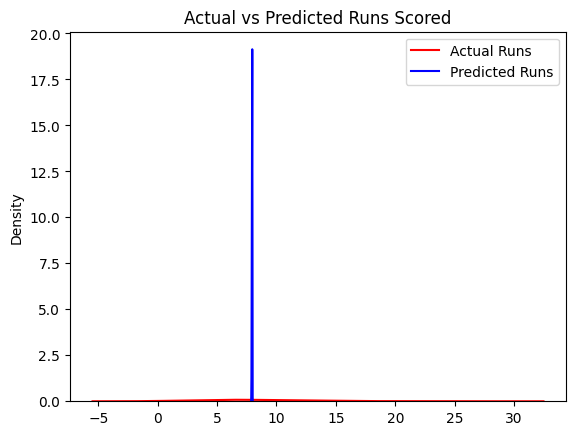

In [117]:
prediction = nn_model_1b.predict(X_test_norm).ravel()
ax = sns.kdeplot(y_test.ravel(), color="r", label="Actual Runs")
sns.kdeplot(prediction, color="b", label="Predicted Runs")
plt.title('Actual vs Predicted Runs Scored')
plt.legend(loc='best')
print("Max prediction =", prediction.max(), "runs")
print("Min prediction =", prediction.min(), "runs")

The near-zero feature importance values below illustrate that the model mostly ignoring the weather data when making its predictions. In fact, the largest value in absolute terms is negative for "Humidity". This means that the most signficant predictor is increasing loss and making the model less accurate. 

3/3 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Feature Importance')

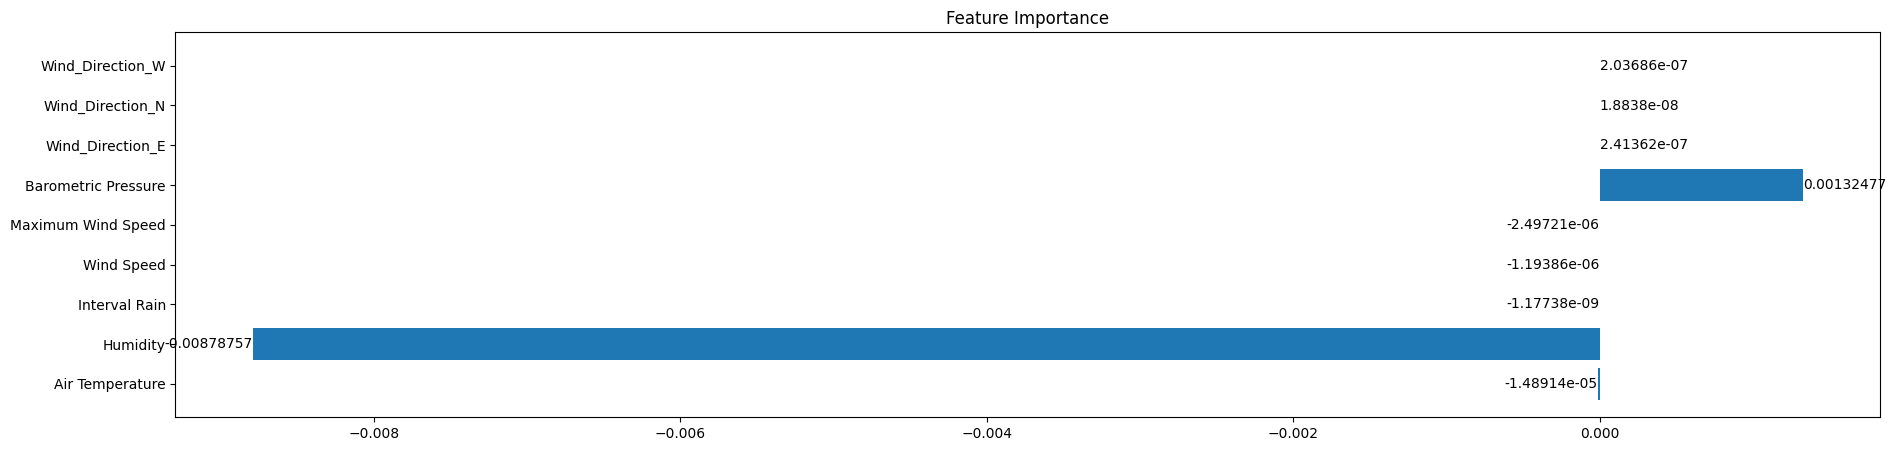

In [118]:
r = permutation_importance(nn_model_1b, X_test_norm, y_test_array, scoring='neg_mean_absolute_error', random_state=4)

order = ['Air Temperature',	'Humidity',	'Interval Rain',	'Wind Speed',	'Maximum Wind Speed',	'Barometric Pressure', 'Wind_Direction_E',	'Wind_Direction_N',	'Wind_Direction_W']
fig, ax = plt.subplots(figsize=(22,5))
bars = ax.barh(order, r.importances_mean)
ax.bar_label(bars)
plt.title('Feature Importance')

#Conclusion

The table below lists the MAE from the best regression, random forest, and neural network models. Multilinear regression was my "best" model for predicting accurate scores at Wrigley. It produces the lowest test data MAE of 3.633 runs, and it is the least overfit model with a discrepancy of only 0.130 runs between the train and test MAE. In addition, regression models have the advantage of being more easily interpretable because I know how the predictions are calculated.

In [119]:
# assign data
mydata = [
    ["Linear Regression", "3.503", "3.633", "*****"],
    ["Random Forest", "3.047", "3.861", ""],
    ["Neural Network", "3.602", "3.910", ""],
    
]
 
# create header
head = ["Model Type", "Train MAE", "Test MAE", "Best Model"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+-------------------+-------------+------------+--------------+
| Model Type        |   Train MAE |   Test MAE | Best Model   |
+===================+=============+============+==============+
| Linear Regression |       3.503 |      3.633 | *****        |
+-------------------+-------------+------------+--------------+
| Random Forest     |       3.047 |      3.861 |              |
+-------------------+-------------+------------+--------------+
| Neural Network    |       3.602 |      3.91  |              |
+-------------------+-------------+------------+--------------+


Was I able to successfully predict the score at Wrigley based on weather conditions? The answer is relative. An MAE between between 3.633-3.910 runs is not exactly precise when the standard deviation of the whole dataset is 4.716 runs. The neural network, in particular, was disappointing because it failed to consider the weather data when making predictions and just hugged the median of 8 runs.

That being said, I was trying to predict baseball, a sport that is notoriously unpredictable, without using baseball data, only the weather. The regression model did successfully quantify how weather can influence the game in a way that makes intuitive sense. Rising temperatures along with favorable winds from the west or south increase total runs. In terms of explanatory power, it is quite remarkable that the weather can account for 5.9% of the variance in run scoring.

The impact of the weather on Wrigley Field is real and measurable. If you show up there on a summery day with the wind blowing out of the park from the west, you might want to take the over bet on the total number of runs scored. Just don't hold me accountable.